# **Scaler DSML Portfolio Project - Network Anomaly Detection**
#### by **Atharva Nitin Deshpande** (DSML August 2024 Batch)

## 1. Introduction

### 1.1 Problem Statement and Objective

In the realm of cybersecurity, network anomaly detection is a critical task that involves identifying unusual patterns or behaviors that deviate from the norm within network traffic. These anomalies could signify a range of security threats, from compromised devices and malware infections to large-scale cyber-attacks like DDoS (Distributed Denial of Service). The challenge lies in accurately detecting these anomalies in real-time, amidst the vast and continuous streams of network data, which are often noisy and heterogeneous.

In this project, the objective is to design an end-to-end machine learning pipeline for intrusion detection, covering the entire lifecycle: exploratory data analysis (EDA), hypothesis formulation and testing, model training, evaluation, and deployment considerations. The system follows a two-stage architecture:

1. Binary classification to detect whether a network connection is normal or malicious.

2. Multiclass classification to identify the specific attack category once an intrusion is detected.

### 1.2 Importing Required Libraries and Raw Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import seaborn as sns
import warnings

from scipy import stats
import statsmodels.api as sm

from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler, 
    FunctionTransformer)
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import (
    train_test_split, 
    StratifiedKFold, 
    RandomizedSearchCV)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    AdaBoostClassifier,
    GradientBoostingClassifier,
    StackingClassifier)

from sklearn.metrics import (
    roc_auc_score, 
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay)

from joblib import dump
from IPython.display import Markdown, display

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.4f}'.format)

Let us now import the raw data.

In [3]:
raw_data = pd.read_csv(r'G:\00000 SCALER BUSINESS CASES\PORTFOLIO PROJECTS\Network-Anomaly-Detection\data\Network_anomaly_data.csv')

In [4]:
raw_data.head().T

,0,1,2,3,4
duration,0,0,0,0,0
protocoltype,tcp,udp,tcp,tcp,tcp
service,ftp_data,other,private,http,http
flag,SF,SF,S0,SF,SF
srcbytes,491,146,0,232,199
dstbytes,0,0,0,8153,420
land,0,0,0,0,0
wrongfragment,0,0,0,0,0
urgent,0,0,0,0,0
hot,0,0,0,0,0


In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   duration                125973 non-null  int64  
 1   protocoltype            125973 non-null  object 
 2   service                 125973 non-null  object 
 3   flag                    125973 non-null  object 
 4   srcbytes                125973 non-null  int64  
 5   dstbytes                125973 non-null  int64  
 6   land                    125973 non-null  int64  
 7   wrongfragment           125973 non-null  int64  
 8   urgent                  125973 non-null  int64  
 9   hot                     125973 non-null  int64  
 10  numfailedlogins         125973 non-null  int64  
 11  loggedin                125973 non-null  int64  
 12  numcompromised          125973 non-null  int64  
 13  rootshell               125973 non-null  int64  
 14  suattempted         

Let's check for any missing values or duplicate rows.

In [6]:
# Missing values check
print("Number of missing values in the dataset: ", raw_data.isna().sum().sum())

# Duplicate rows check
print("Number of duplicate rows in the dataset: ", raw_data.duplicated().sum())

Number of missing values in the dataset:  0
Number of duplicate rows in the dataset:  0


### 1.3 Defining The 4 Major Attack Types

The Network Attacks are widely classified into the following 4 categories:

- **Denial of Service (DoS)** 
    
    These attacks aim to disrupt availability by overwhelming a target with excessive traffic or malformed requests, causing legitimate users to be unable to access services. E.g. These attacks try to shut down a website or service by flooding it with too many requests, making it unavailable to real users.

- **Probe** 

    These attacks focus on reconnaissance, where attackers scan networks or hosts to discover open ports, running services, or potential vulnerabilities before launching more targeted attacks. E.g. These attacks are like digital scouting, where attackers quietly look for weak points or open doors in a system.

- **Remote to Local (R2L)** 

    These attacks occur when an external attacker gains unauthorized local access by exploiting weaknesses such as weak passwords or misconfigurations, often without generating high traffic volumes. E.g. These attacks happen when someone outside the system manages to log in without permission, often by guessing or stealing credentials.

- **User to Root (U2R)** 

    These attacks involve a local user escalating privileges to gain root or administrative access, typically through software vulnerabilities, and are rare but highly impactful. E.g. These attacks occur when a user with limited access manages to gain full control of a system, which is rare but very serious.

Let us define these types via new feature `attacktype`.

In [7]:
df = raw_data.copy(deep=True)
df['attackflag'] = raw_data['attack'].apply(lambda x: 0 if x=='normal' else 1)

def type_of_attack(attack):
    # Denial of Service (DoS) attacks
    DoS = [
        "back",
        "land",
        "neptune",
        "pod",
        "smurf",
        "teardrop",
        "mailbomb",
        "apache2",
        "processtable",
        "udpstorm"
    ]

    # Probe (surveillance / scanning) attacks
    Probe = [
        "satan",
        "ipsweep",
        "nmap",
        "portsweep",
        "mscan",
        "saint"
    ]

    # Remote to Local (R2L) attacks
    R2L = [
        "guess_passwd",
        "ftp_write",
        "imap",
        "phf",
        "multihop",
        "warezmaster",
        "warezclient",
        "spy",
        "xlock",
        "xsnoop",
        "snmpguess",
        "snmpgetattack",
        "httptunnel",
        "sendmail",
        "named"
    ]

    # User to Root (U2R) attacks
    U2R = [
        "buffer_overflow",
        "loadmodule",
        "rootkit",
        "perl",
        "sqlattack",
        "xterm",
        "ps"
    ]
    if attack == 'normal':
        return 'normal'
    elif attack in DoS:
        return 'DoS'
    elif attack in Probe:
        return 'Probe'
    elif attack in R2L:
        return 'R2L'
    elif attack in U2R:
        return 'U2R'
    
    return 'other'

df['attacktype'] = df['attack'].apply(type_of_attack)
attacks_DoS = df[df['attacktype']=='DoS']['attack']
attacks_Probe = df[df['attacktype']=='Probe']['attack']
attacks_R2L = df[df['attacktype']=='R2L']['attack']
attacks_U2R = df[df['attacktype']=='U2R']['attack']
attacks_all = df[df['attack'] != 'normal']['attack']

attacktypes = df['attacktype'].copy(deep=True)
attacktypes_within_attacks = df[df['attackflag']==1]['attacktype'].copy(deep=True)

attackflags_text = df['attackflag'].copy(deep=True).map({0:'normal',1:'attack'})

In [8]:
_original_show = plt.show

def auto_save_show(*args, **kwargs):
    os.makedirs('../plots', exist_ok=True)
    for num in plt.get_fignums():
        fig = plt.figure(num)
        ts = datetime.now().strftime("%Y%m%d_%H%M%S_%f")
        fig.savefig(f'../plots/fig_{ts}.png', dpi=600, bbox_inches='tight')
        _original_show(*args, **kwargs)

plt.show = auto_save_show

### 1.4 Removal of Features with very high Modal Frequency (>99%)

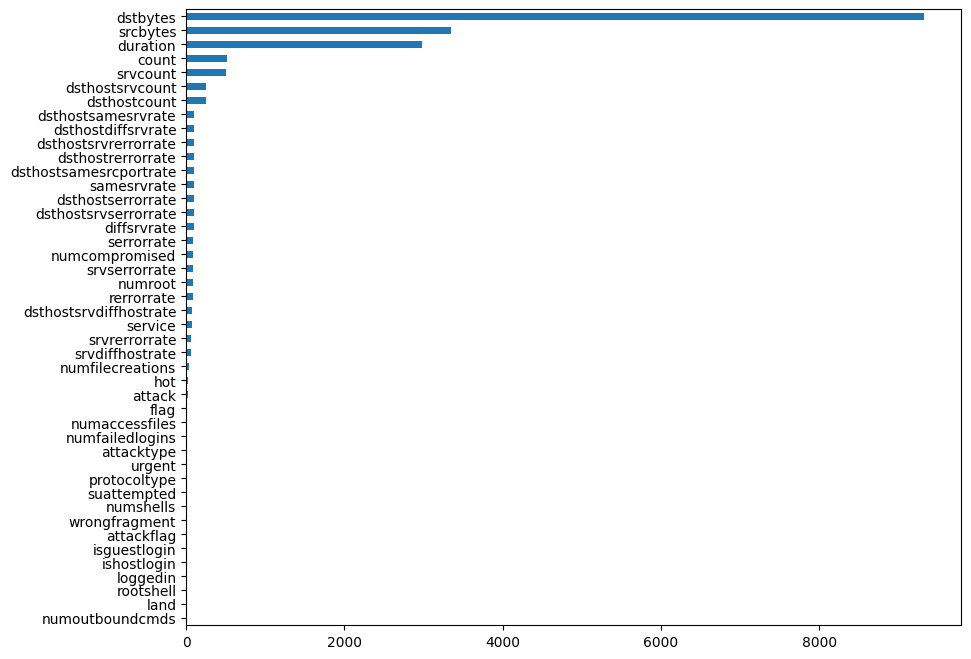

In [ ]:
plt.figure(figsize=(10,8))
df.nunique().sort_values(ascending=True).plot(kind='barh')
plt.show()

In [10]:
pd.concat(
    [
        df.nunique(), 
        df.dtypes, 
        df.mode().T[0], 
        df.apply(lambda col: col.value_counts(normalize=True).iloc[0])
        ], 
        axis=1, 
        keys=[
            'No. of Unique Values',
            'Data Type',
            'Mode',
            'Mode Frequency'
            ]
            ).sort_values(by=['Data Type','Mode Frequency', 'No. of Unique Values'], ascending=[True, False, True])

,No. of Unique Values,Data Type,Mode,Mode Frequency
numoutboundcmds,1,int64,0,1.0000
ishostlogin,2,int64,0,1.0000
urgent,4,int64,0,0.9999
land,2,int64,0,0.9998
numshells,3,int64,0,0.9996
suattempted,3,int64,0,0.9994
numfailedlogins,6,int64,0,0.9990
rootshell,2,int64,0,0.9987
numfilecreations,35,int64,0,0.9977
numaccessfiles,10,int64,0,0.9971


For columns with modal frequency > 99%, we will first check the attack distribution for non-modal classes of each column.

In [11]:
for col in df.nunique().sort_values().index:
    if df[col].value_counts(normalize=True).iloc[0] >= 0.99:
        text = col + f' ({df.shape[0] - df[col].value_counts().iloc[0]} non-modal values)'
        l = len(text)
        print('-'*int(30-l/2),text.upper(),'-'*int(30-l/2))
        x = df[df[col] != df[col].mode().iloc[0]]['attack'].value_counts()
        print(x)
        print('\n')

------------ NUMOUTBOUNDCMDS (0 NON-MODAL VALUES) ------------
Series([], Name: count, dtype: int64)


----------------- LAND (25 NON-MODAL VALUES) -----------------
attack
land      18
normal     7
Name: count, dtype: int64


-------------- ROOTSHELL (169 NON-MODAL VALUES) --------------
attack
normal             137
buffer_overflow     18
phf                  4
loadmodule           3
perl                 3
rootkit              2
multihop             2
Name: count, dtype: int64


-------------- ISHOSTLOGIN (1 NON-MODAL VALUES) --------------
attack
normal    1
Name: count, dtype: int64


------------ ISGUESTLOGIN (1187 NON-MODAL VALUES) ------------
attack
normal          873
warezclient     306
ftp_write         2
warezmaster       2
multihop          2
satan             1
guess_passwd      1
Name: count, dtype: int64


----------- WRONGFRAGMENT (1090 NON-MODAL VALUES) -----------
attack
teardrop    892
pod         198
Name: count, dtype: int64


-------------- NUMSHELLS (47 NON-MODA

We can see that, the non-modal rows are tiny fractions of the data. Moreover, we cannot see any significant association between a specific attack and column, even when conditioned on only non-modal values. Thus, these columns add very little-to-no informative value for ML modelling. Hence, these columns can be discarded as well.

Let us further verify this decision by checking the Mutual Information (MI) Scores. MI measures how much information the presence or absence of a feature contributes to making the correct prediction on the target (attack).

In [12]:
print('MUTUAL INFORMATION SCORES:')
for col in df.drop(columns='attack'): 
    X = df[[col]].apply(lambda x: pd.factorize(x)[0])
    y = df['attack']

    # For Classification
    mi_score = mutual_info_classif(X, y, discrete_features=[True])
    if mi_score <= 0.1:
        print(f"{col.upper()}{' '*(30-len(col)-6)}{round(mi_score[0],4)}")

MUTUAL INFORMATION SCORES:
DURATION                0.0844
LAND                    0.0013
WRONGFRAGMENT           0.0534
URGENT                  0.0002
HOT                     0.0619
NUMFAILEDLOGINS         0.0034
NUMCOMPROMISED          0.0403
ROOTSHELL               0.0021
SUATTEMPTED             0.0005
NUMROOT                 0.0039
NUMFILECREATIONS        0.0027
NUMSHELLS               0.0007
NUMACCESSFILES          0.0022
NUMOUTBOUNDCMDS         0.0
ISHOSTLOGIN             0.0
ISGUESTLOGIN            0.0116


The MI scores for the columns previously identified above for discarding are very low. Hence it is safe to discard these columns.

In [13]:
for col in raw_data:
    if df[col].value_counts(normalize=True).iloc[0]>=0.99:
        print(f'Dropping column: {col}')
        df.drop(columns=col, inplace=True)

Dropping column: land
Dropping column: wrongfragment
Dropping column: urgent
Dropping column: numfailedlogins
Dropping column: rootshell
Dropping column: suattempted
Dropping column: numroot
Dropping column: numfilecreations
Dropping column: numshells
Dropping column: numaccessfiles
Dropping column: numoutboundcmds
Dropping column: ishostlogin
Dropping column: isguestlogin


In [14]:
df.columns

Index(['duration', 'protocoltype', 'service', 'flag', 'srcbytes', 'dstbytes',
       'hot', 'loggedin', 'numcompromised', 'count', 'srvcount', 'serrorrate',
       'srvserrorrate', 'rerrorrate', 'srvrerrorrate', 'samesrvrate',
       'diffsrvrate', 'srvdiffhostrate', 'dsthostcount', 'dsthostsrvcount',
       'dsthostsamesrvrate', 'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'attack', 'attackflag',
       'attacktype'],
      dtype='object')

## 2. Exploratory Data Analysis (EDA)

### 2.1 Defining Numerical and Categorical Features

In [15]:
df_num = df.select_dtypes(exclude='object')
df_cat = df.select_dtypes(include='object')
df_cat['attackflag'] = df['attackflag'].copy(deep=True)

In [16]:
df_num.columns

Index(['duration', 'srcbytes', 'dstbytes', 'hot', 'loggedin', 'numcompromised',
       'count', 'srvcount', 'serrorrate', 'srvserrorrate', 'rerrorrate',
       'srvrerrorrate', 'samesrvrate', 'diffsrvrate', 'srvdiffhostrate',
       'dsthostcount', 'dsthostsrvcount', 'dsthostsamesrvrate',
       'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'attackflag'],
      dtype='object')

In [17]:
df_cat.columns

Index(['protocoltype', 'service', 'flag', 'attack', 'attacktype',
       'attackflag'],
      dtype='object')

### 2.2 Univariate Analysis

#### 2.2.1 Numerical Features

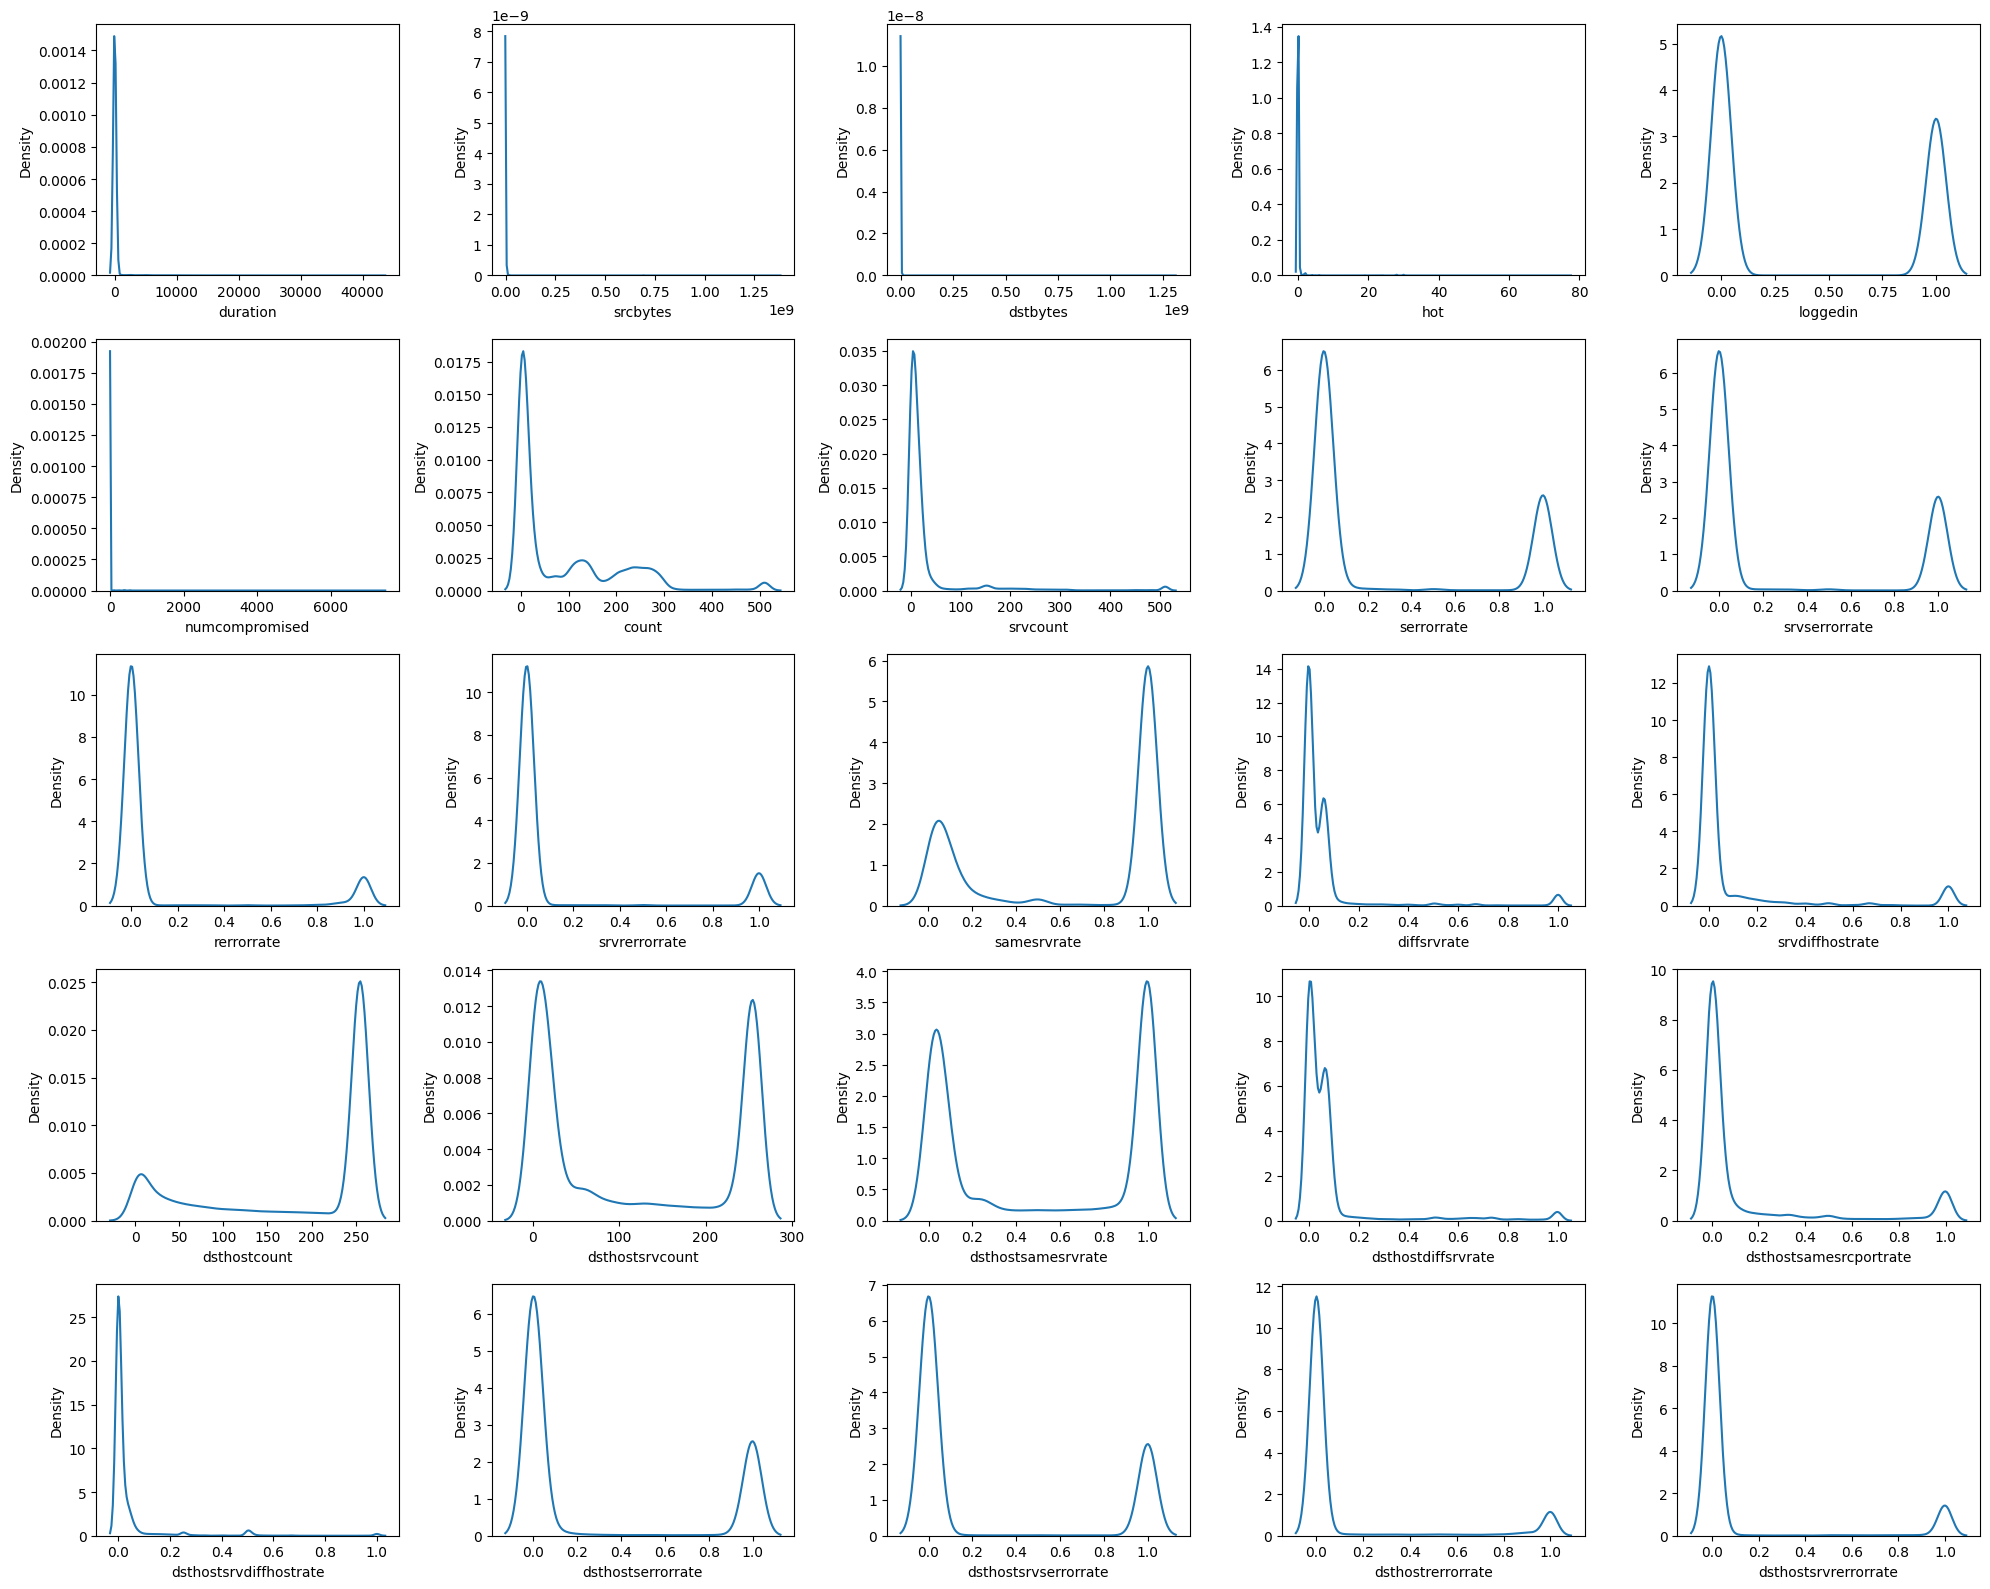

In [18]:
grid_size = int(np.ceil((df_num.shape[1]-1)**0.5))

plt.figure(figsize=(20,16))
for i,col in enumerate(df_num):
    if col != 'attackflag':
        plt.subplot(grid_size, grid_size, i+1)
        sns.kdeplot(data=df_num, x=col)
plt.tight_layout()
plt.show()

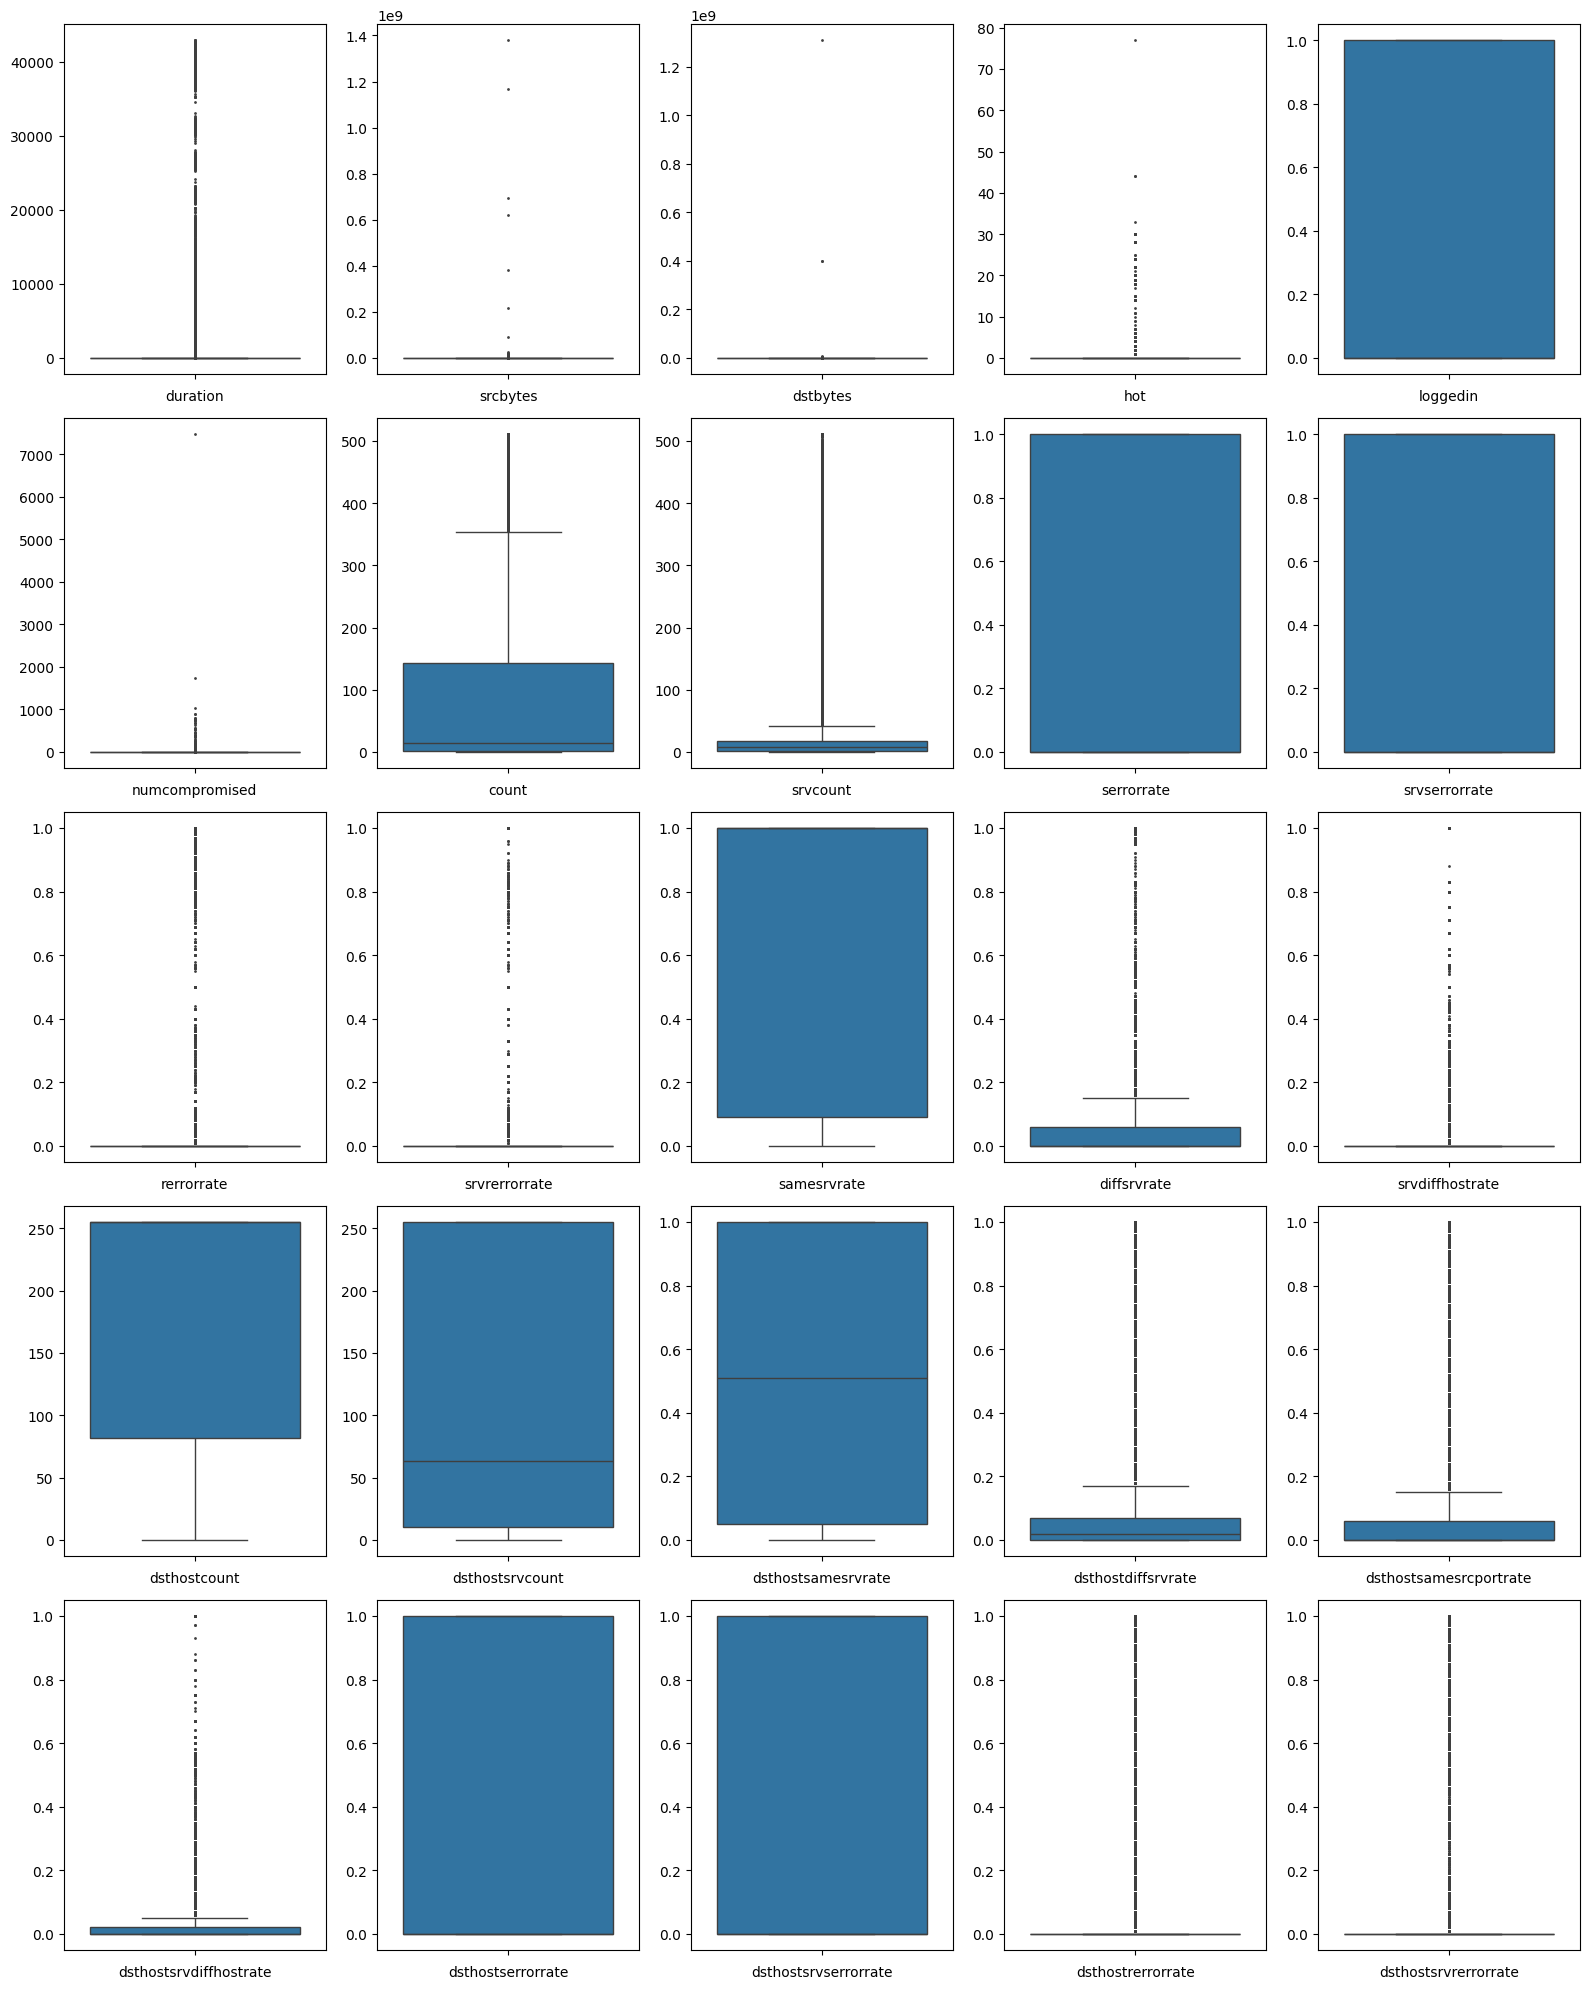

In [19]:
grid_size = int(np.ceil((df_num.shape[1]-1)**0.5))

plt.figure(figsize=(16,20))
for i,col in enumerate(df_num):
    if col != 'attackflag':
        plt.subplot(grid_size, grid_size, i+1)    
        sns.boxplot(data=df_num, y=col, fliersize=1)
        plt.xlabel(col)
        plt.ylabel('')
plt.tight_layout()
plt.show()

**Insights:**

- Most features exhibit **strong right skewness**, with values concentrated near zero and a small number of extreme observations.

- **Duration, source bytes, and destination bytes show particularly heavy tails**, indicating mostly short, low-volume connections with a few very large transfers.

- Count-based variables (e.g., `count`, `srvcount`, `dsthostcount`, `dsthostsrvcount`) have long right tails, suggesting repetitive or bursty connection behavior in a minority of cases.

- Outliers are prevalent across many features, especially in traffic volume and connection count metrics, likely corresponding to anomalous or attack-related activity.

- `numcompromised` is mostly zero with rare large values, making it a sparse but potentially strong indicator of compromise.

- Binary or near-binary behavior is evident in loggedin, clearly separating logged-in and non-logged-in sessions.

- Many rate-based features (e.g., `serrorrate`, `srvserrorrate`, `rerrorrate`, `srvrerrorrate`) cluster near 0 with a secondary peak near 1, indicating sharp transitions between normal and abnormal traffic.

- Host-based rate features (dsthost*rate) consistently show bimodal distributions, suggesting strong discriminative power for intrusion detection.

- Service similarity measures (`samesrvrate`, `dsthostsamesrvrate`) display clear separation between diverse-service normal traffic and repeated-service attack patterns.

- Difference-based service rates (`diffsrvrate`, `dsthostdiffsrvrate`) are mostly close to zero, indicating limited service switching in most connections.

- The dominance of extreme values implies a need for log scaling prior to modeling.

#### 2.2.2 Categorical Features

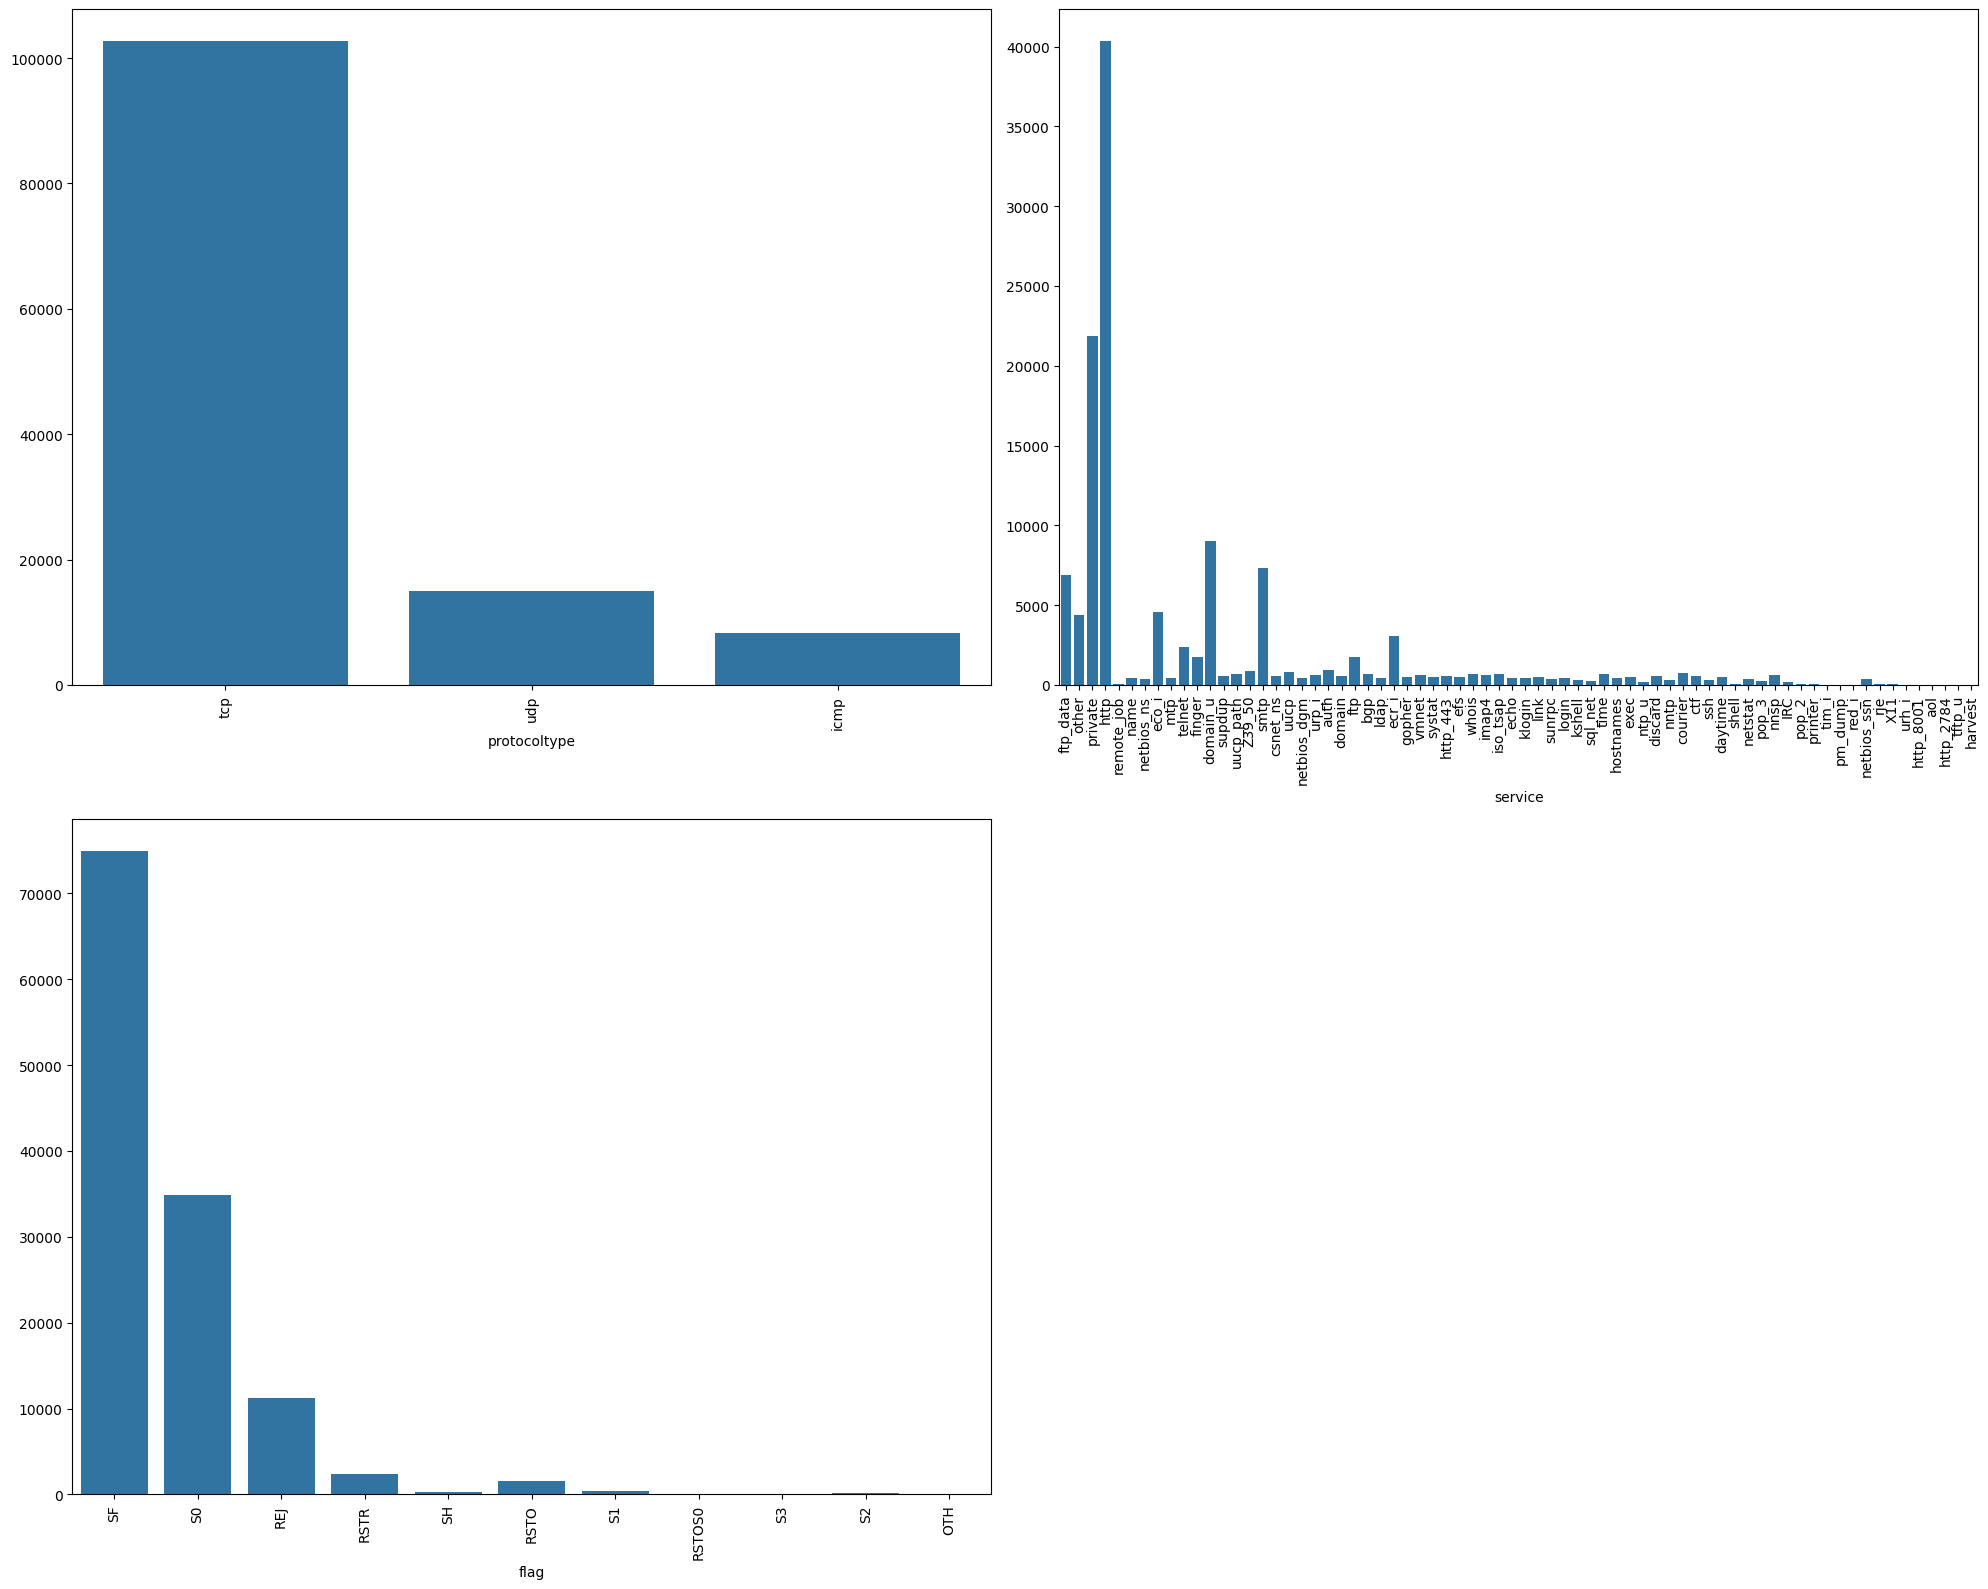

In [20]:
grid_size = int(np.ceil((df_cat.shape[1]-3)**0.5))

plt.figure(figsize=(20,16))
for i,col in enumerate(df_cat):
    if 'attack' not in col:
        plt.subplot(grid_size, grid_size, i+1)
        sns.countplot(data=df_cat, x=col)
        plt.xlabel(col)
        plt.xticks(rotation=90)
        plt.ylabel('')
plt.tight_layout()
plt.show()

**Insights:**

- **TCP dominates the protocol distribution**, accounting for the majority of connections, while UDP is significantly less frequent and ICMP appears relatively rare.

- The **service feature is highly imbalanced**, with a small number of services (e.g., HTTP-related and common network services) accounting for most connections, and many services occurring very infrequently.

- The long tail in the service distribution indicates **high categorical sparsity**, which may require grouping rare services or using robust encoding techniques.

- **Connection flags are strongly skewed**, with `SF` being the most common state, followed by `S0`, while other flags occur much less frequently.

- The prevalence of `S0`, `REJ`, and other non-`SF` flags suggests a **substantial presence of failed or incomplete connections**, which can be indicative of scanning or attack behavior.

- Overall, the categorical features exhibit **class imbalance**, implying that careful encoding and imbalance-aware modeling strategies are necessary.


### 2.3 Bivariate Analysis (Normal vs. Attack)

#### 2.3.1 Normal vs. Attack Distribution

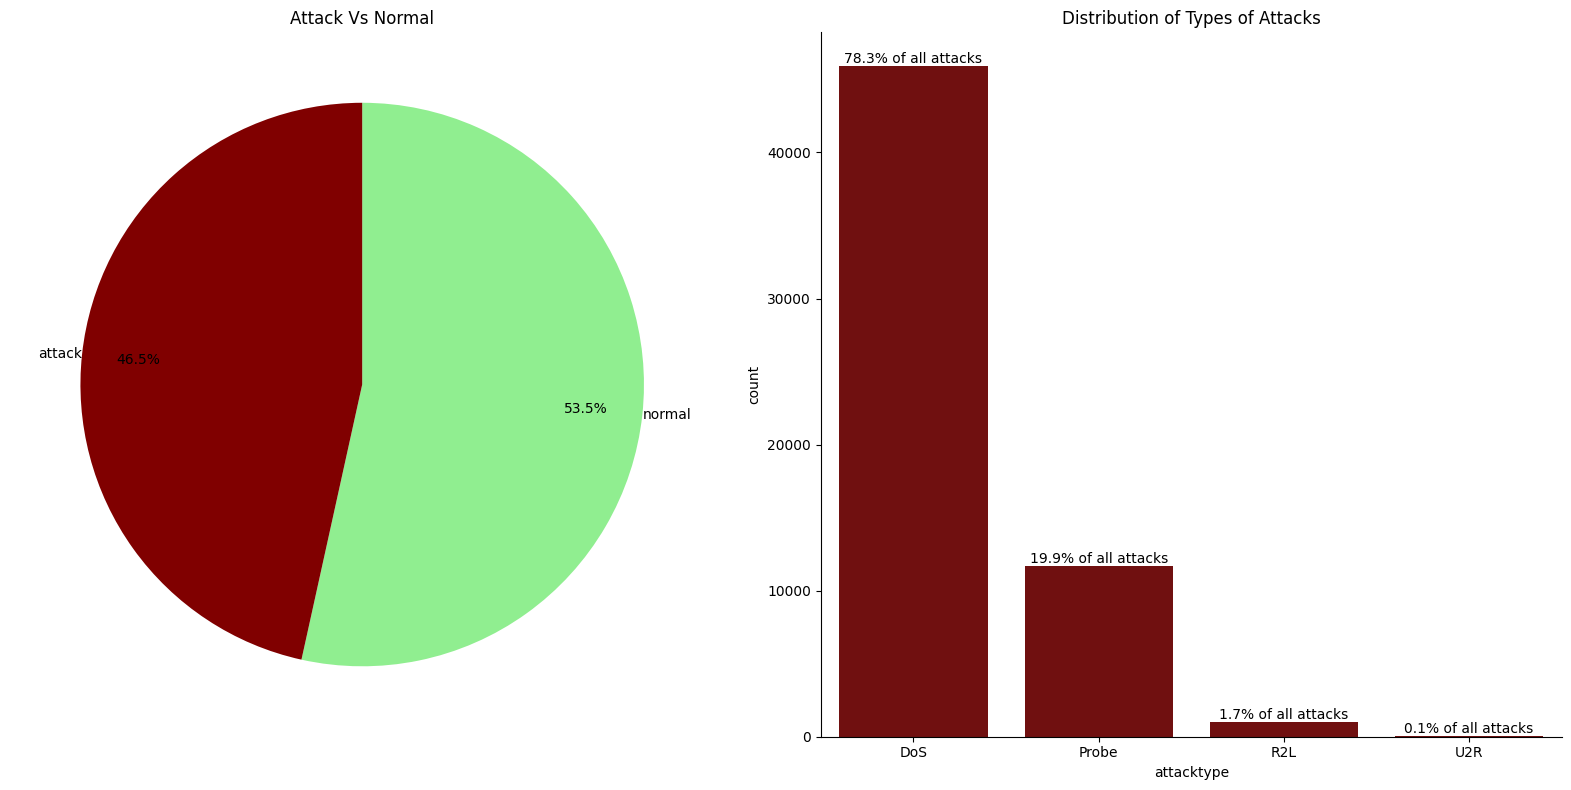

In [21]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.title('Attack Vs Normal')
plt.pie(attackflags_text.value_counts(), 
        labels=attackflags_text.value_counts().index,
        explode=[0,0] + [0.5]*(attackflags_text.nunique()-2), 
        autopct='%1.1f%%', 
        counterclock=False,
        startangle=90, 
        pctdistance=0.8, 
        labeldistance=1,
        colors=['lightgreen','maroon'])

x = attacktypes_within_attacks.value_counts()

plt.subplot(1,2,2)
plt.title('Distribution of Types of Attacks')
ax = sns.countplot(x=attacktypes_within_attacks, 
                   order=x.index,
                   color='maroon')
total=len(attacktypes_within_attacks)
for p in ax.patches:
    value = int(p.get_height())
    value = str(round(value/total*100,1)) + r"% of all attacks"
    ax.annotate(value,
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

**Insights:**

- **The dataset is fairly balanced between normal and attack traffic**, with normal connections making up ~53.5% and attacks ~46.5%, reducing severe class imbalance concerns for model training.

- **DoS attacks overwhelmingly dominate the attack landscape**, accounting for ~78% of all attacks, indicating the dataset is heavily biased toward availability-based attack patterns.

- **R2L and U2R attacks are extremely rare**, together contributing less than 2% of attacks, which may make them difficult to learn without resampling or specialized modeling techniques.

#### 2.3.2 Numerical Features

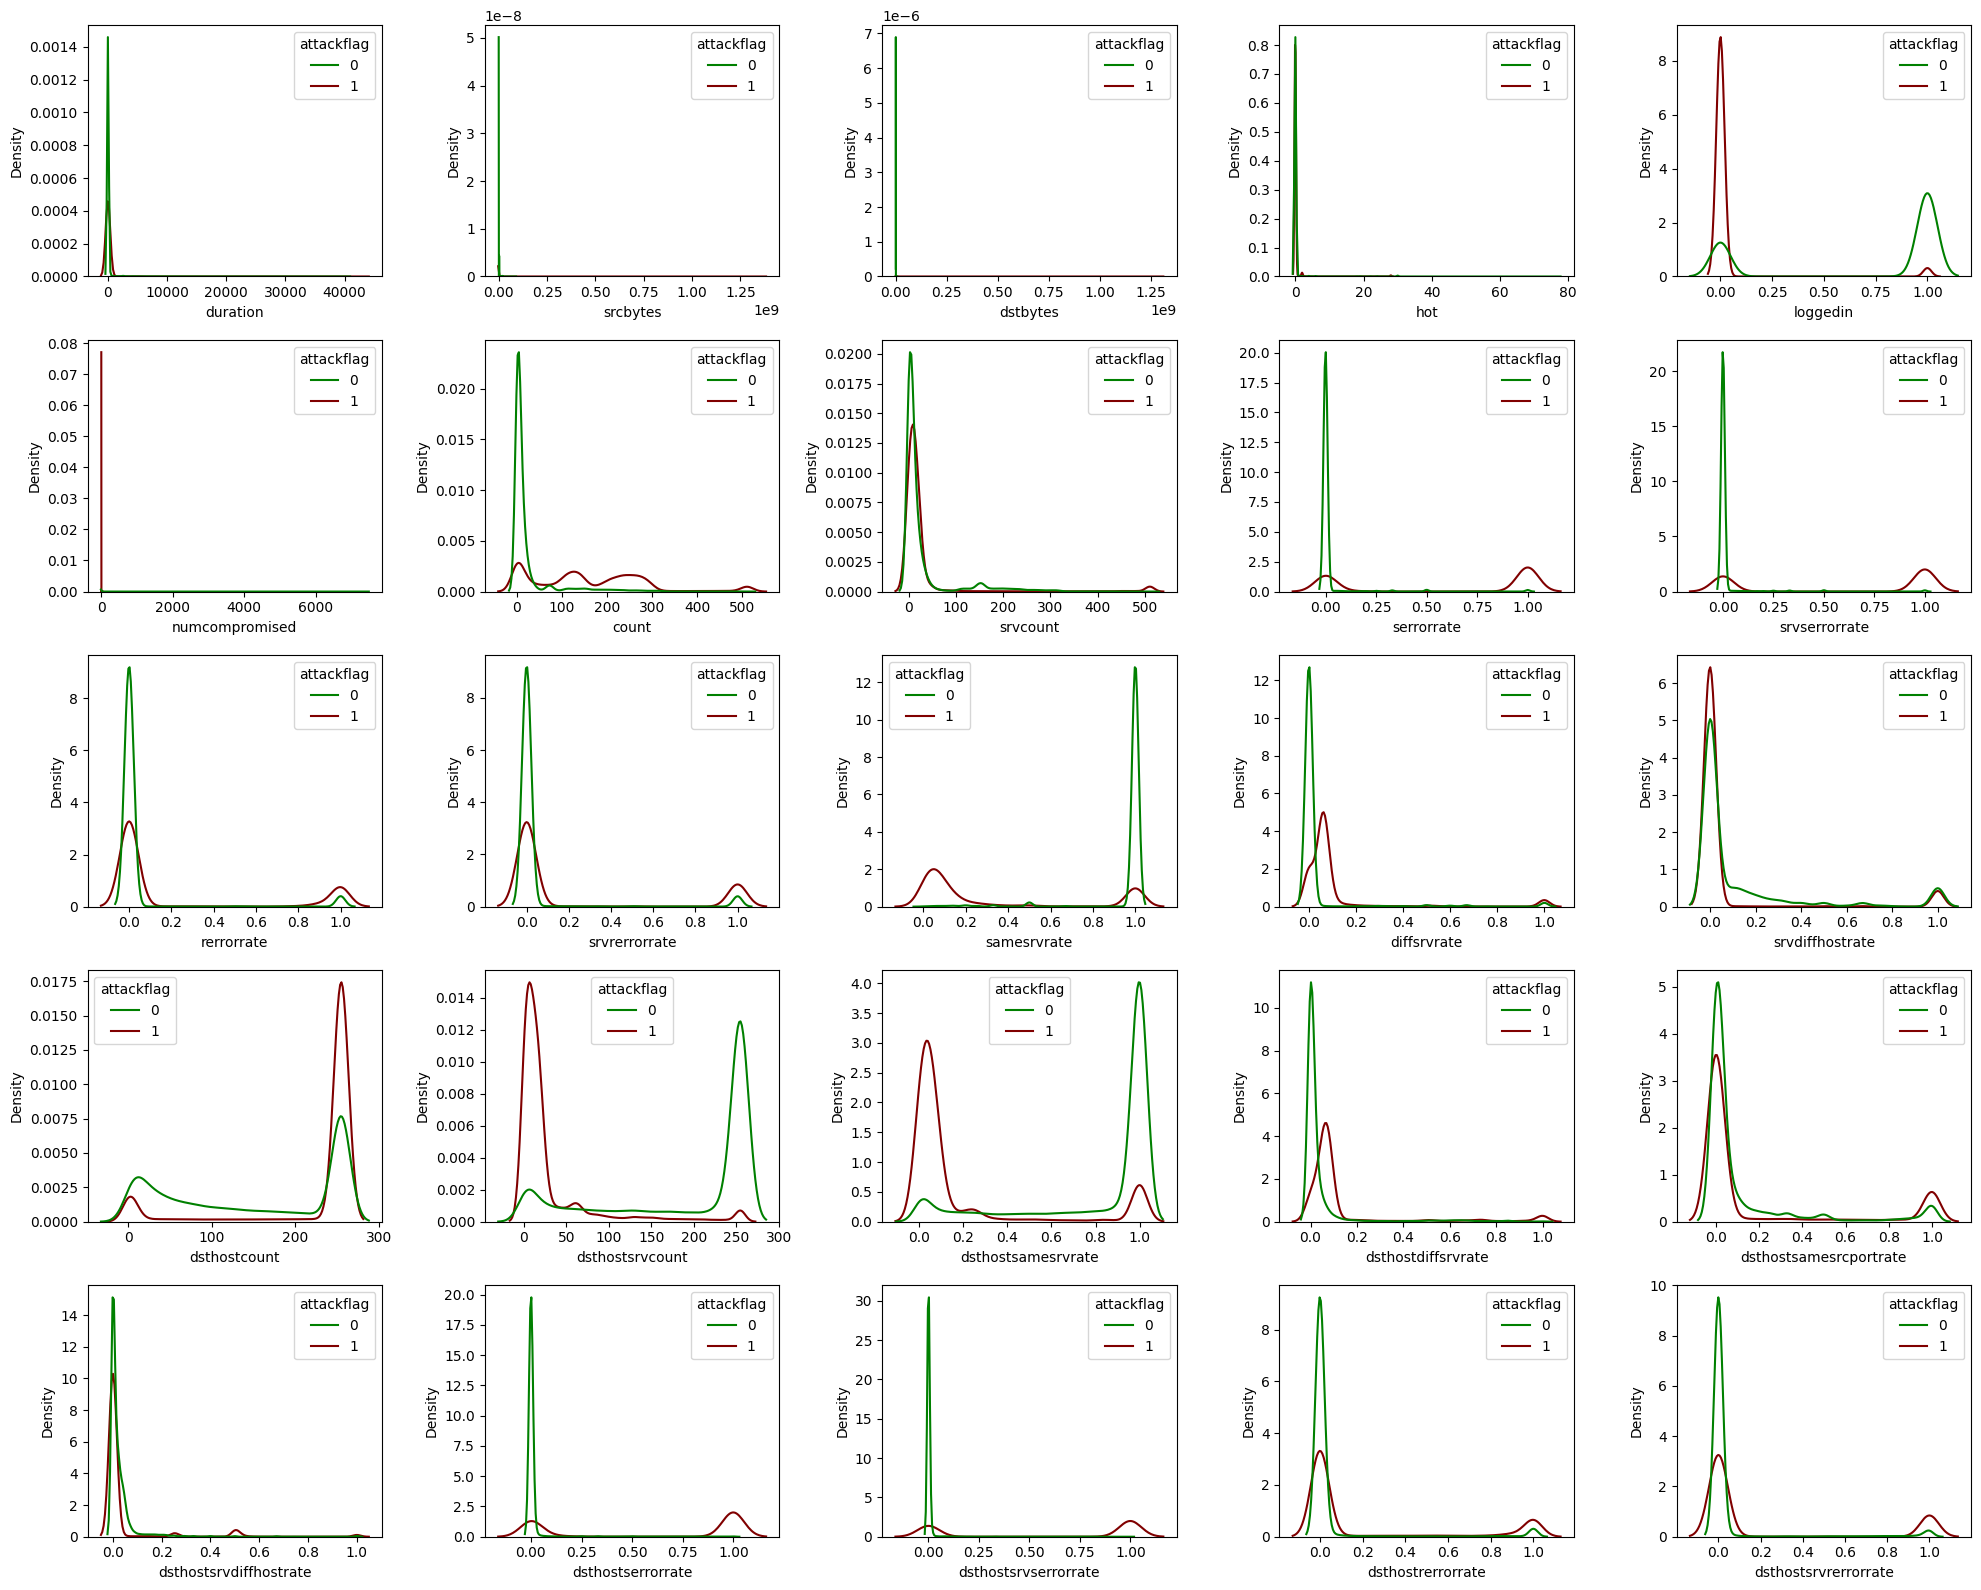

In [22]:
palette = {0:'green',1:'maroon'}
grid_size = int(np.ceil((df_num.shape[1]-1)**0.5))

plt.figure(figsize=(20,16))
for i,col in enumerate(df_num):
    if col != 'attackflag':
        plt.subplot(grid_size, grid_size, i+1)
        sns.kdeplot(data=df_num, 
                    x=col, 
                    hue='attackflag', 
                    palette=palette)
plt.tight_layout()
plt.show()

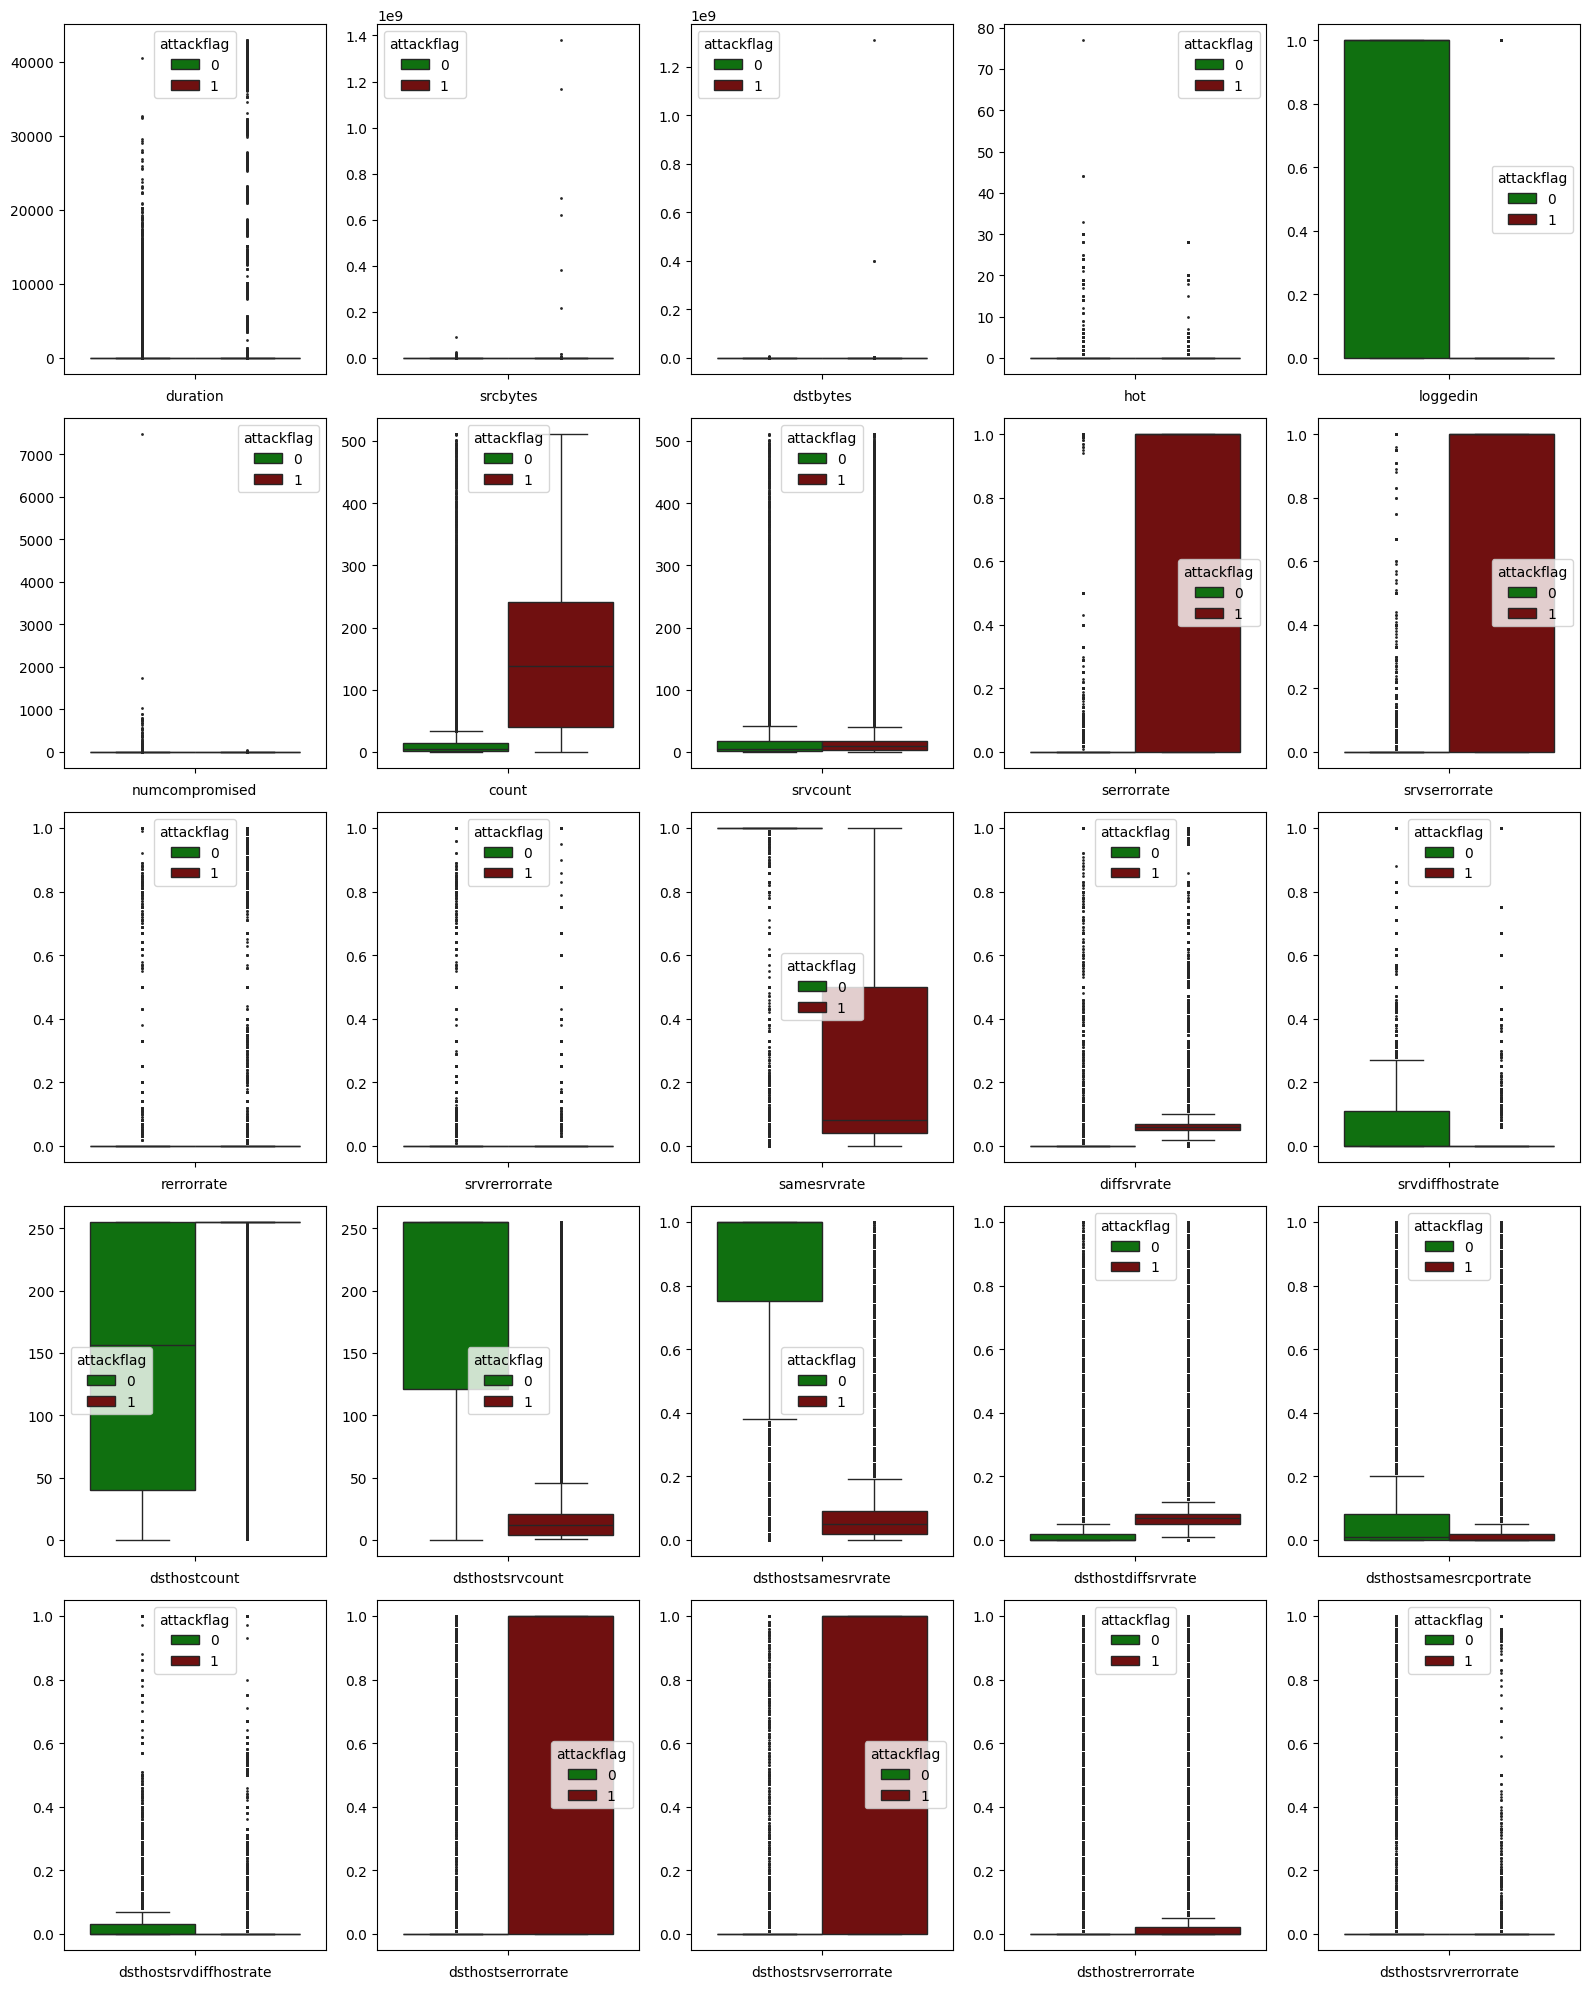

In [23]:
grid_size = int(np.ceil((df_num.shape[1]-1)**0.5))

plt.figure(figsize=(16,20))
for i,col in enumerate(df_num):
    if col != 'attackflag':
        plt.subplot(grid_size, grid_size, i+1)    
        sns.boxplot(data=df_num, 
                    y=col, 
                    hue='attackflag', 
                    fliersize=1,
                    palette=palette)
        plt.xlabel(col)
        plt.ylabel('')
plt.tight_layout()
plt.show()

**Insights**:

- **Attack traffic shows extreme skewness in connection behavior**, with much higher `count`, `srvcount`, and `dsthostcount` values compared to normal traffic, indicating repeated or bursty connection attempts typical of scanning and flooding attacks.

- **Rate-based features are the strongest discriminators**, especially `serrorrate`, `srvserrorrate`, `same_srv_rate`, and their dsthost variants, where attack connections cluster near extreme values (close to 0 or 1) while normal traffic remains more spread out.

- **Error-related metrics are heavily associated with attacks**, as attack-labeled flows exhibit significantly higher SYN error and service error rates, suggesting failed or half-open connections common in DoS and probing activities.

- **Login and privilege-related features are highly imbalanced**, with `loggedin` and `numcompromised` almost exclusively indicating normal behavior, while attacks rarely involve successful authentication.

- **Host-based aggregation features (`dsthost*`) amplify separation**, where attack traffic consistently shows abnormal consistency across hosts and services, reflecting coordinated or automated attack patterns.

#### 2.3.3 Categorical Features

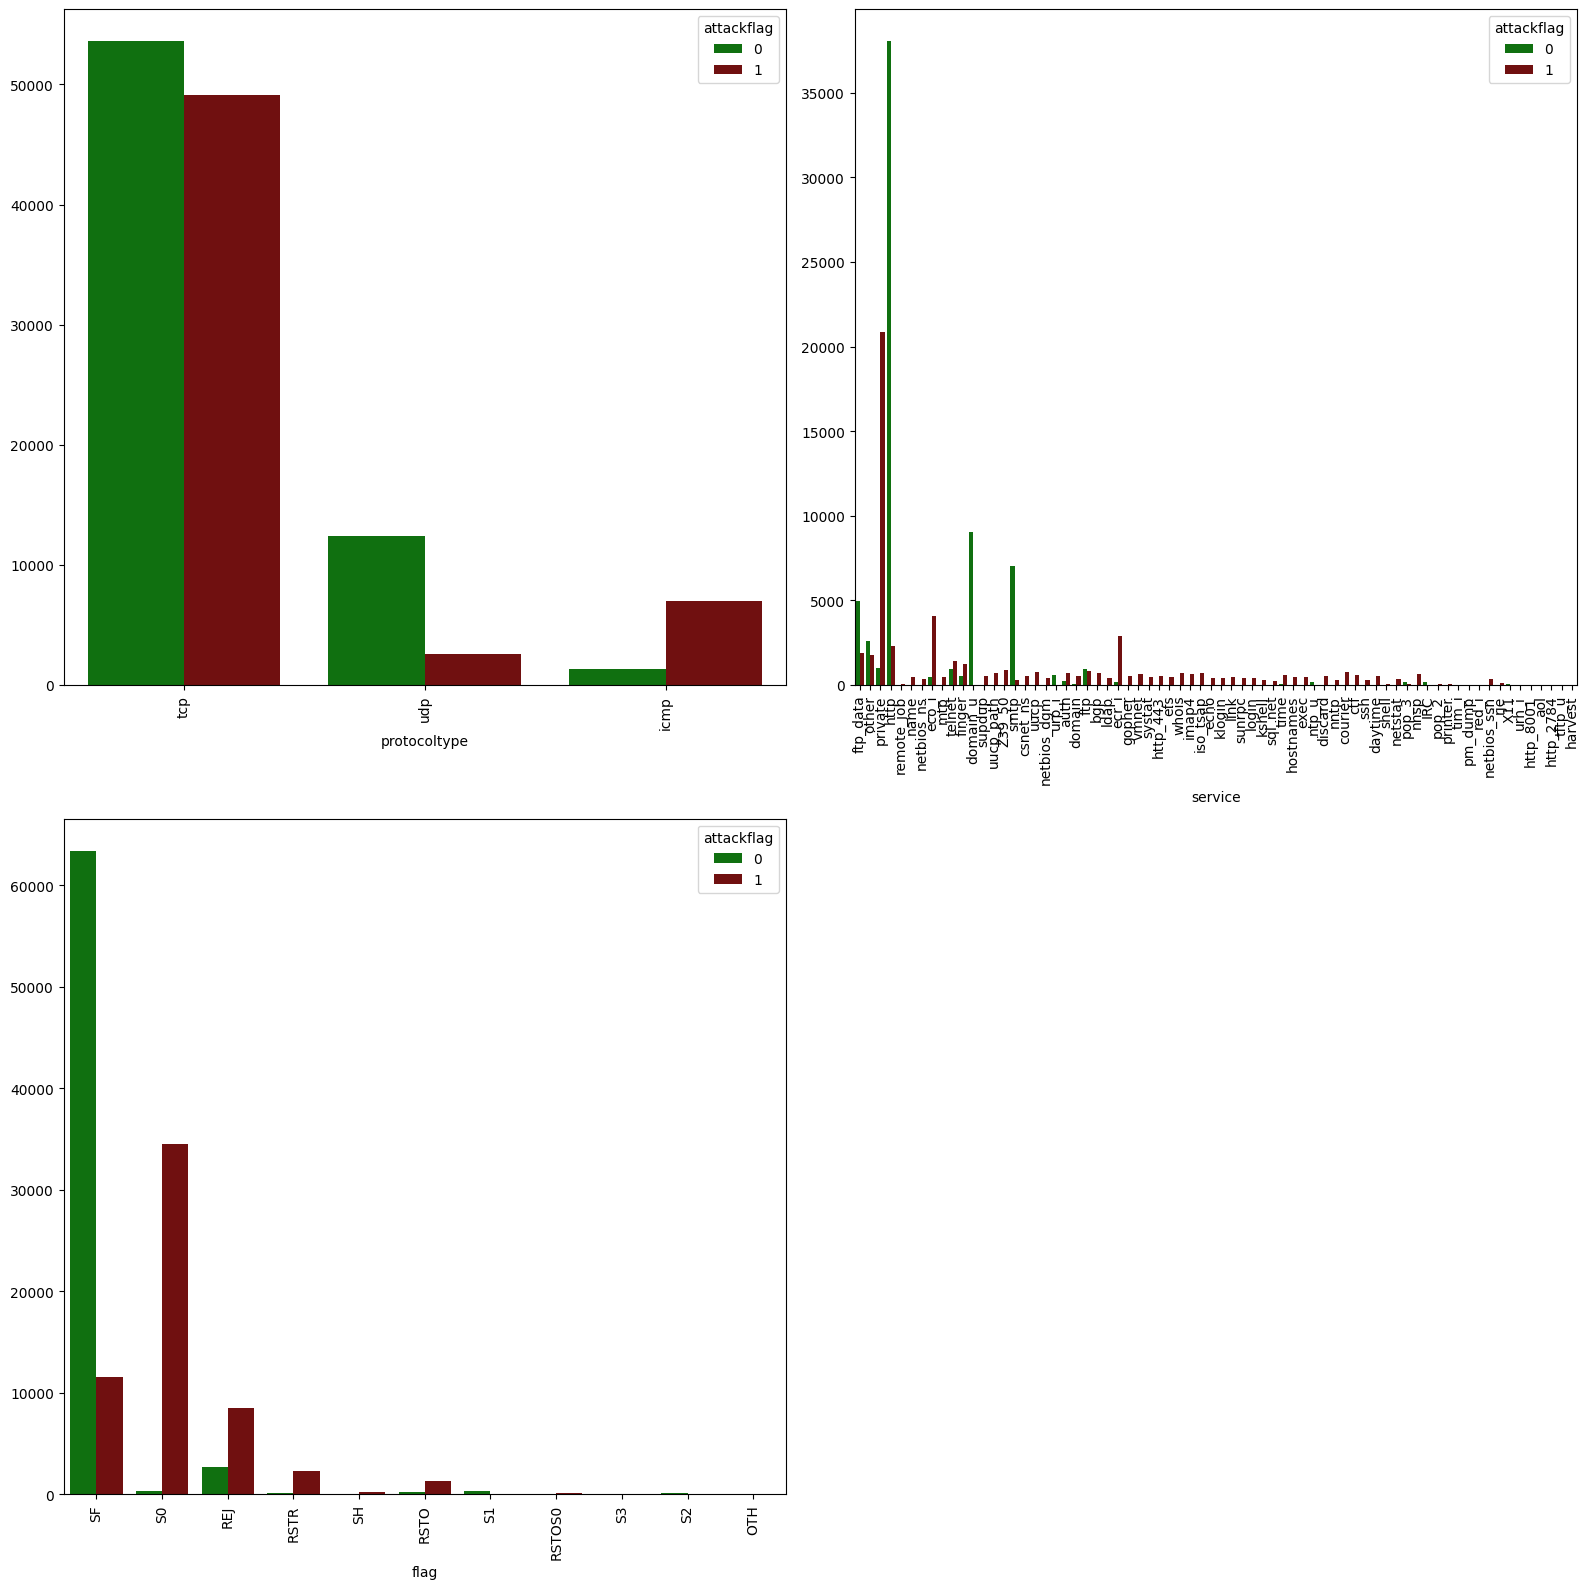

In [ ]:
grid_size = int(np.ceil((df_cat.shape[1]-3)**0.5))

plt.figure(figsize=(16,16))
for i,col in enumerate(df_cat):
    if col not in ['attack','attacktype','attackflag']:
        plt.subplot(grid_size, grid_size, i+1)
        sns.countplot(data=df_cat, 
                      x=col, 
                      hue='attackflag', 
                      palette=palette)
        plt.xlabel(col)
        plt.xticks(rotation=90)
        plt.ylabel('')
plt.tight_layout()
plt.show()

**Insights:**

- **TCP is the most commonly used protocol** for both normal and attack traffic, indicating it is the primary communication channel and a major attack surface.

- **ICMP traffic shows a disproportionately high number of attacks** compared to normal usage, suggesting frequent use in reconnaissance and flooding activities.

- UDP traffic is largely associated with normal behavior, with relatively few attack instances observed in the dataset.

- Services such as **ftp_data, private, http, eco_i, ecr_i, etc.** exhibit higher attack frequencies, highlighting that publicly accessible services are more frequently targeted.

- Normal traffic is dominated by the SF flag (successful connections), while **attack traffic shows higher occurrences of S0, REJ, and RSTR flags**, reflecting failed or abnormal connection attempts.

### 2.4 Multivariate Analysis (Attack Types: DoS/Probe/R2L/U2R)

#### 2.4.1 Distribution of Attack Types

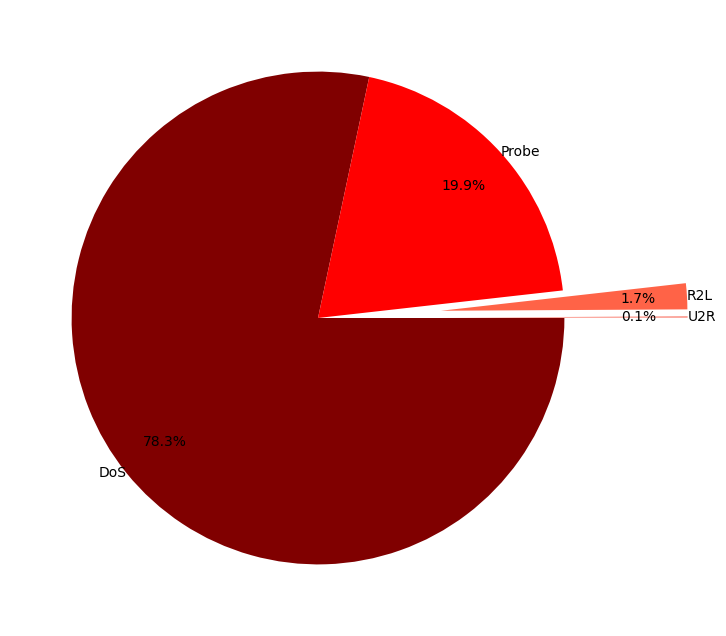

In [110]:
plt.figure(figsize=(8,8))
plt.pie(attacktypes_within_attacks.value_counts(), 
        labels=attacktypes_within_attacks.value_counts().index,
        explode=[0,0] + [0.5]*(attacktypes_within_attacks.nunique()-2), 
        autopct='%1.1f%%', 
        counterclock=False,
        pctdistance=0.8, 
        labeldistance=1,
        colors=['maroon','red','tomato','salmon'], )
plt.show()

**Insights:**

- **DoS attacks dominate the dataset, accounting for approximately 78% of all attacks**, indicating that denial-of-service behavior is the primary threat pattern.

- Probe attacks form a significant secondary category at about 20%, reflecting extensive reconnaissance and scanning activity prior to exploitation.

- R2L and U2R attacks together make up less than 2% of all attacks, highlighting extreme class imbalance and the difficulty of detecting rare but high-impact intrusions.

#### 2.4.2 Distribution of Attacks within each Attack Type

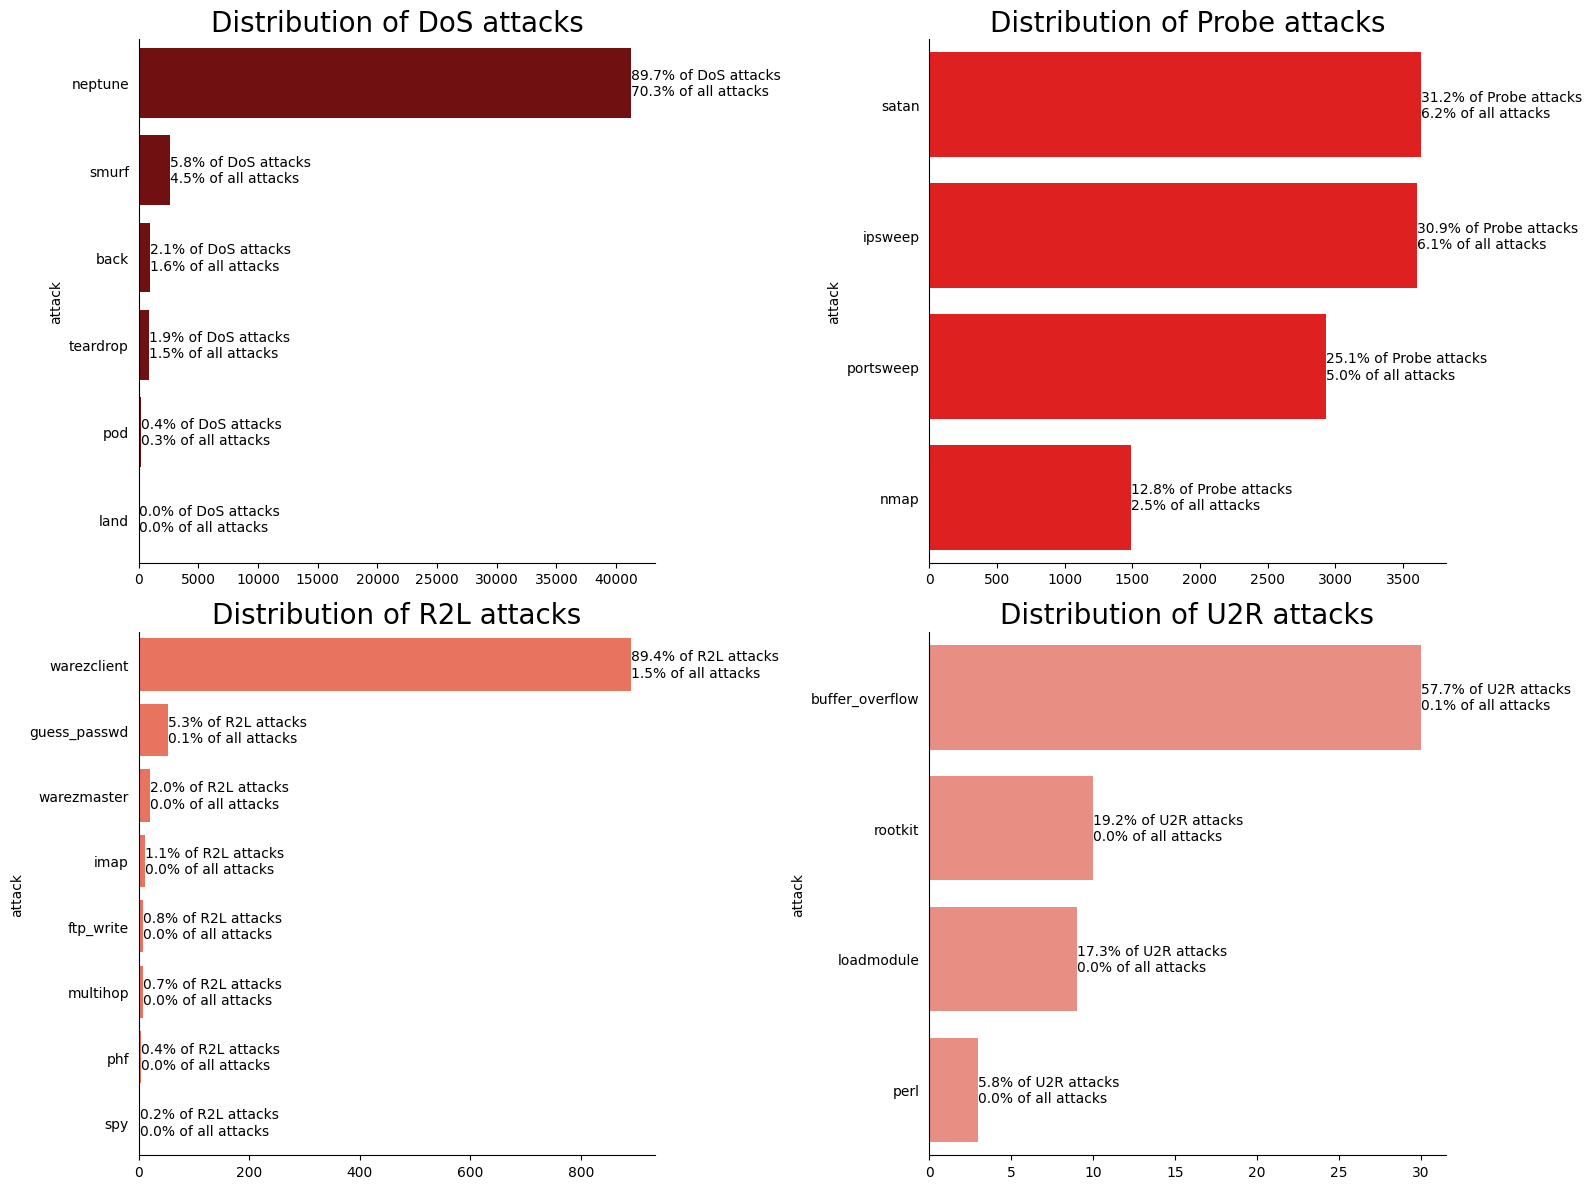

In [25]:
plt.figure(figsize=(16,12))

x = {
    'DoS':attacks_DoS,
    'Probe':attacks_Probe,
    'R2L':attacks_R2L,
    'U2R':attacks_U2R
}

i=1
colors = ['maroon','red','tomato','salmon']
total = len(attacktypes_within_attacks)
for k,s in x.items():
    vc = s.value_counts()
    plt.subplot(2,2,i)
    plt.title(f'Distribution of {k} attacks',size=20)
    ax = sns.countplot(y=s,
                  order=vc.index,
                  color=colors[i-1])
    subtotal = len(s)
    for p in ax.patches:
        count = int(p.get_width())
        text1 = str(round(count/subtotal*100,1)) + r"% of " + k + " attacks"
        text2 = str(round(count/total*100,1)) + r"% of all attacks"
        text = text1 + '\n' + text2
        ax.annotate(text,
                    (count, p.get_y() + p.get_height()/2),
                    ha='left', 
                    va='center')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    plt.xlabel('')
    # plt.xticks(rotation=90)
    i+=1
    
plt.tight_layout()
plt.show()

**Insights:**

- DoS attacks are overwhelmingly dominated by the **neptune** attack, accounting for nearly 90% of all DoS incidents and over 70% of total attacks, indicating a severe class imbalance.

- Probe attacks are more evenly distributed, with **satan, ipsweep, and portsweep** together forming the majority, suggesting diverse reconnaissance techniques.

- R2L attacks are highly concentrated, with **warezclient** making up almost 90% of R2L cases, while other R2L attack types occur very rarely.

- U2R attacks are extremely scarce overall, but **buffer_overflow** is the most prominent within this category, representing more than half of U2R attacks.

- The attack dataset is heavily skewed toward a few dominant attack types, which may bias machine learning models if not handled with resampling or class-weighting techniques.

- Rare attack classes (especially U2R and minor R2L types) are difficult to learn from due to low frequency, increasing the risk of false negatives in intrusion detection systems.

#### 2.4.3 Numerical Features

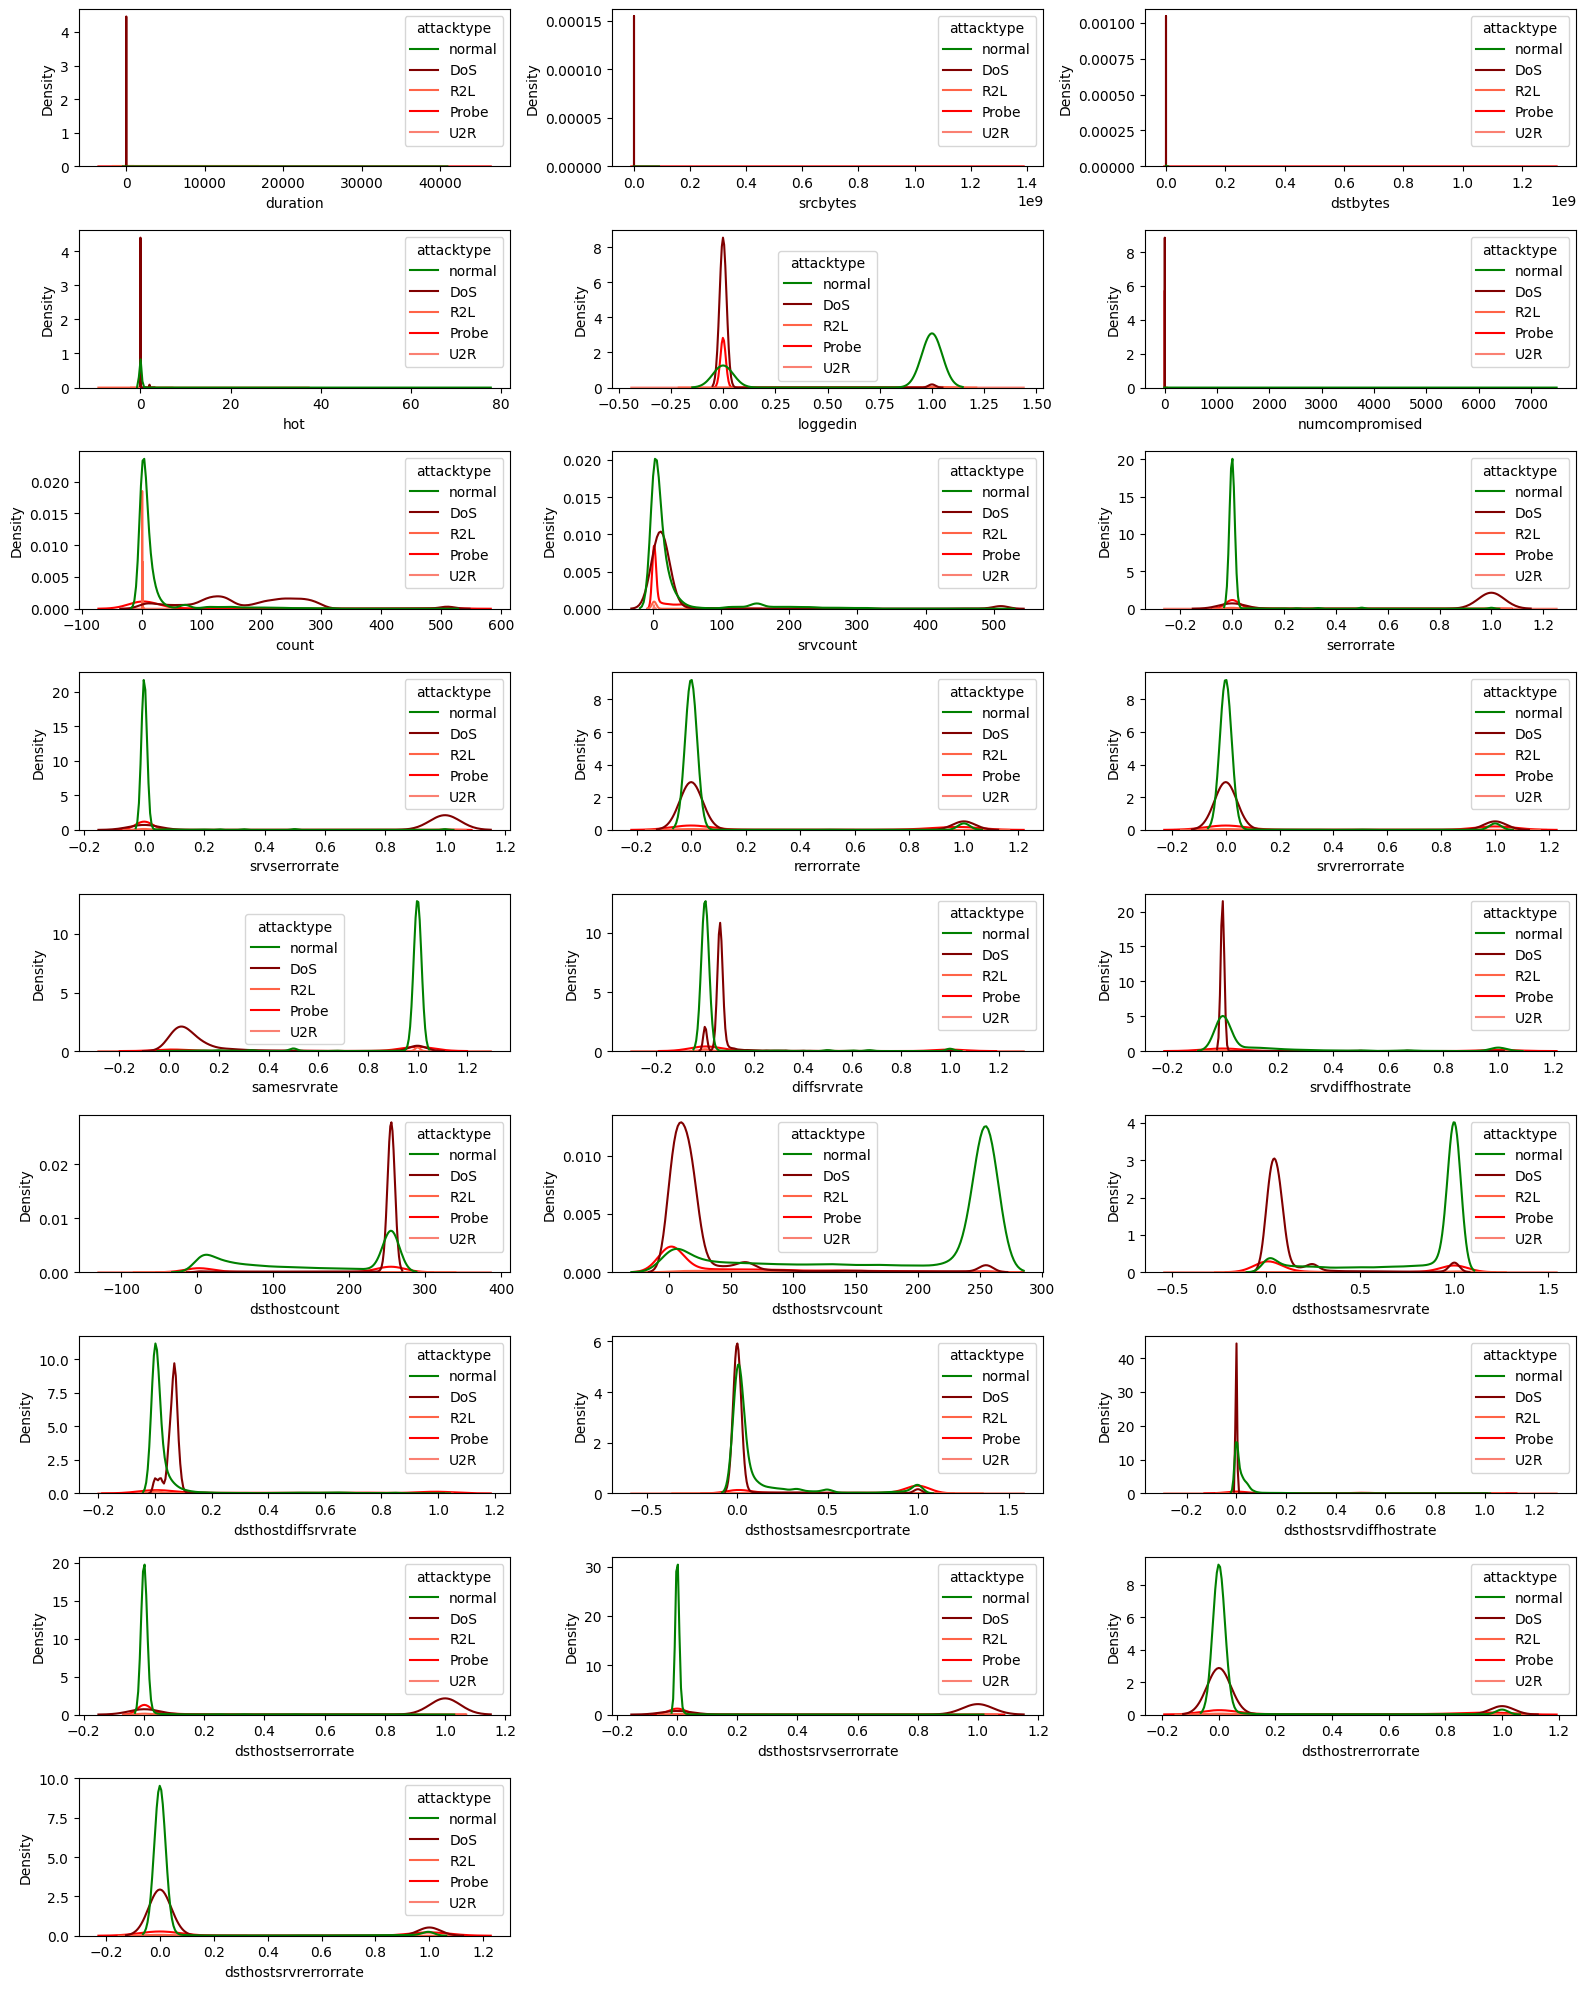

In [26]:
df_num1 = df_num.copy(deep=True)
df_num1['attacktype'] = df['attacktype']

palette = {
    'normal':'green',
    'DoS':'maroon',
    'Probe':'red',
    'R2L':'tomato',
    'U2R':'salmon'
}

grid_ht = int(np.ceil((df_num1.shape[1]-2)/3))

plt.figure(figsize=(16,20))
i=1
for col in df_num1:
    if col not in ['attacktype','attackflag']:
        plt.subplot(grid_ht, 3, i)
        sns.kdeplot(data=df_num1, 
                    x=col, 
                    hue='attacktype', 
                    palette=palette)
        i+=1
plt.tight_layout()
plt.show()

**Insights:**

- Duration, srcbytes, and dstbytes show heavy right-skew; DoS traffic concentrates near zero duration with extreme byte outliers.

- Loggedin clearly separates classes: normal connections peak near 1, while most attack types cluster near 0.

- Count and srvcount are higher and more dispersed for DoS and Probe attacks, indicating repeated connection attempts.

- Error-rate features (serrorrate, srvserrorrate, rerrorrate) peak near 1 for DoS, while normal traffic stays near 0.

- Host-based features (dsthostcount, dsthostsrvcount) show strong separation, with attacks exhibiting higher densities at large values.

- R2L and U2R often overlap with normal in many distributions, suggesting they are harder to distinguish using single features.

#### 2.4.4 Categorical Features

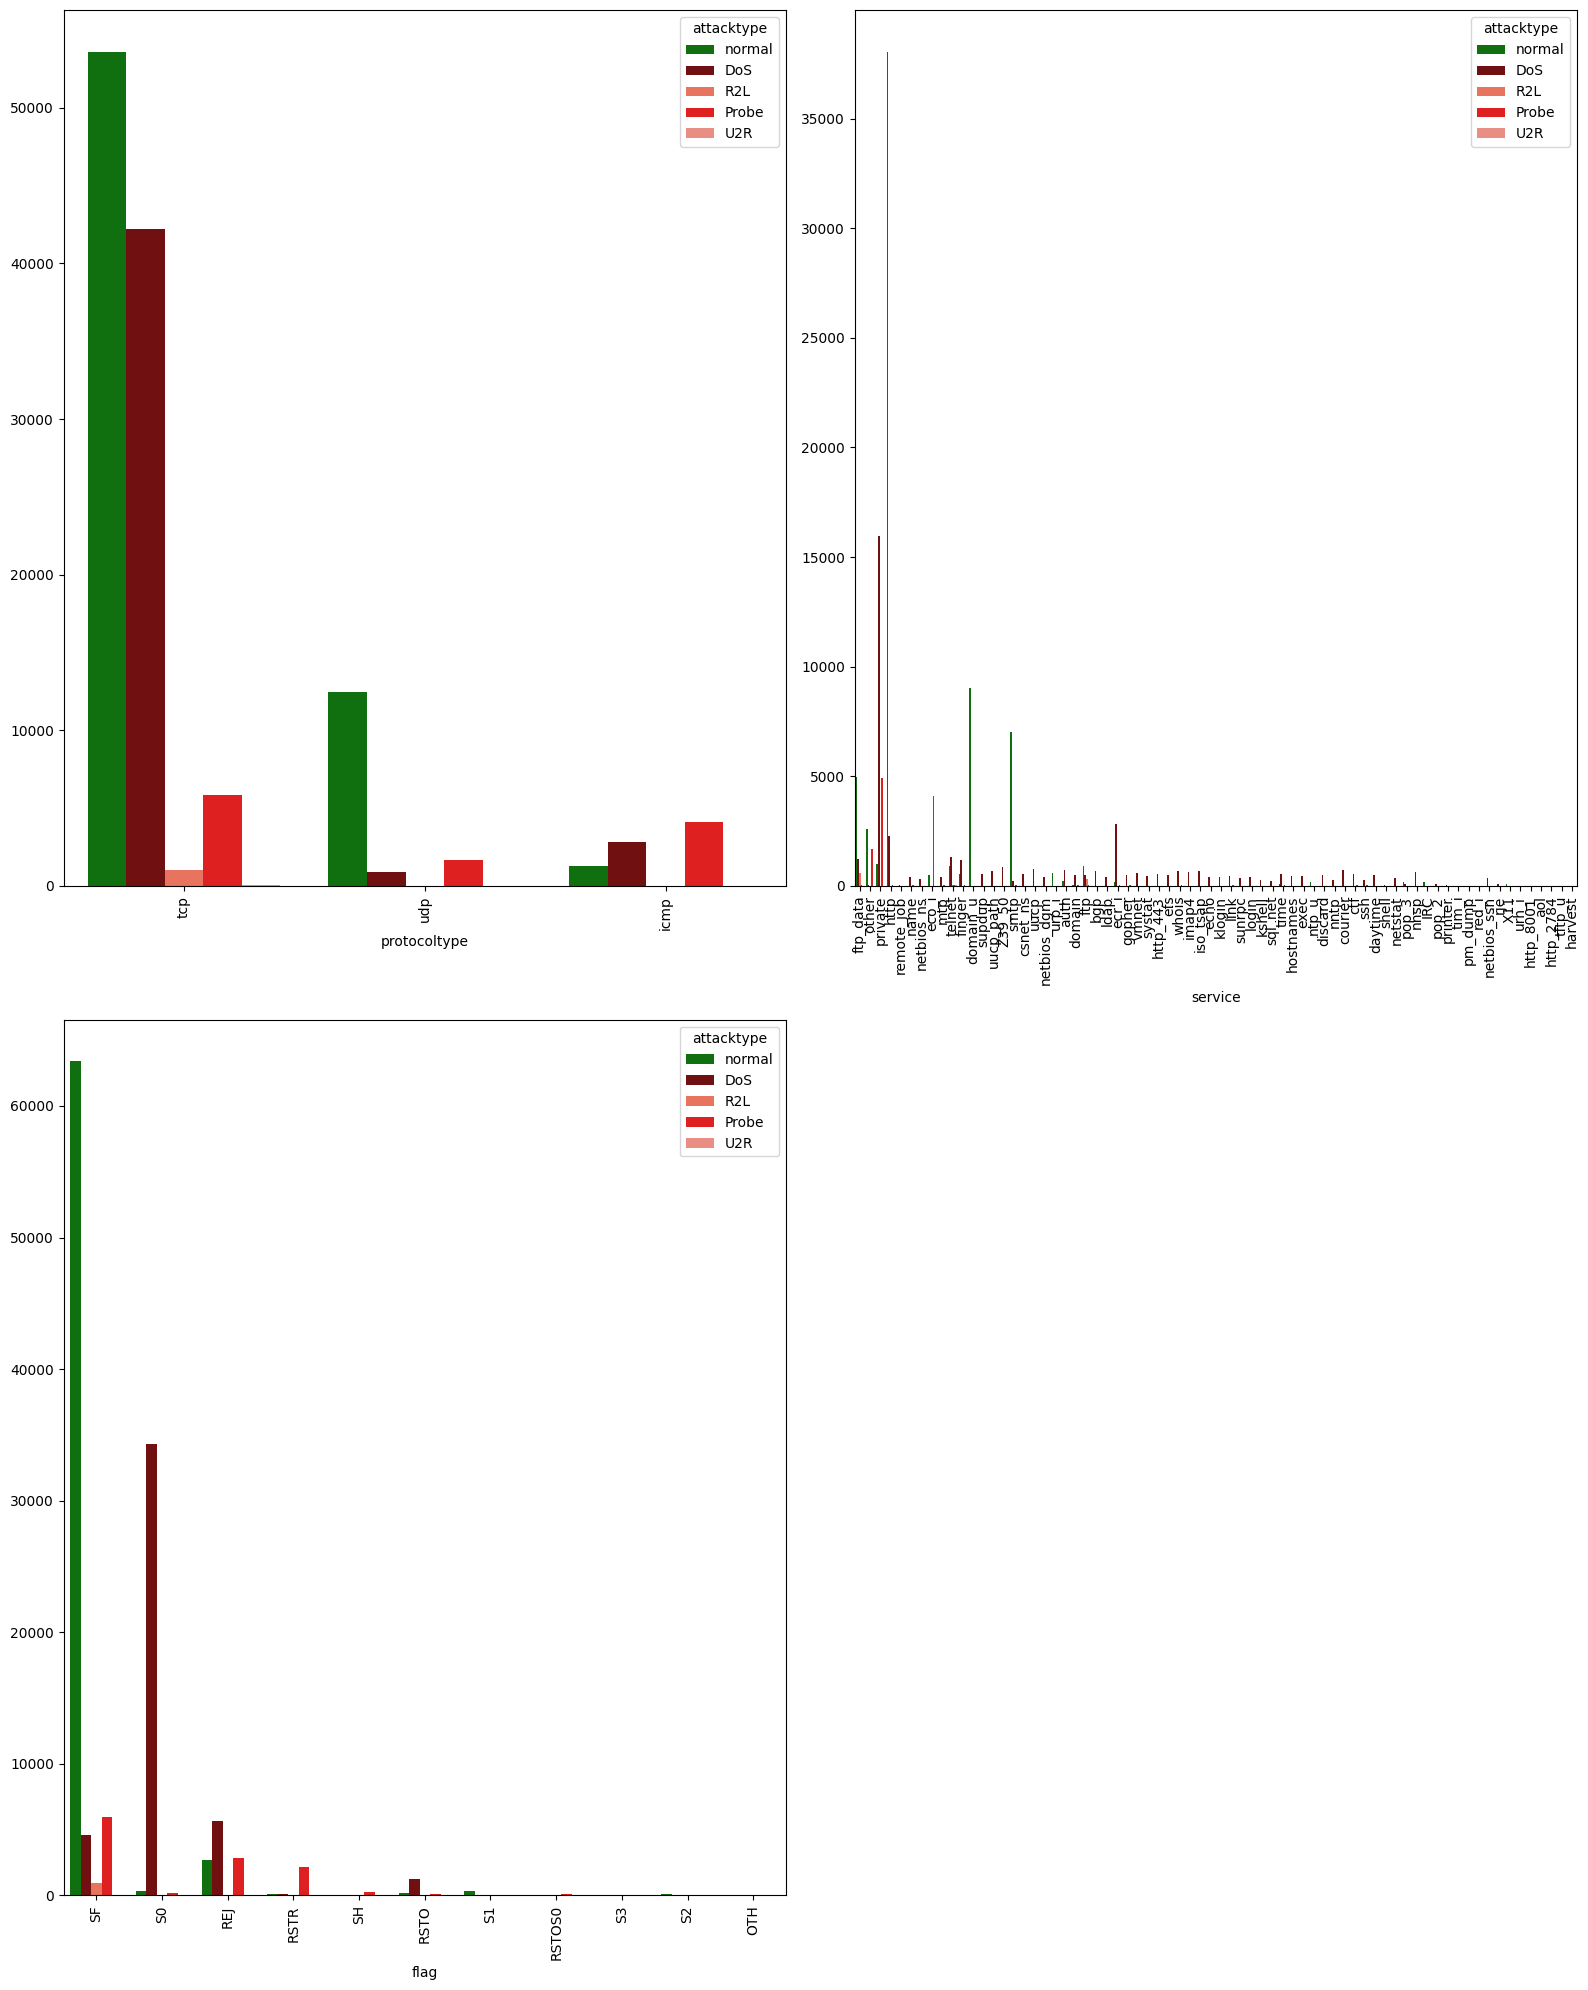

In [27]:
grid_ht = int(np.ceil((df_cat.shape[1]-3)/2))

plt.figure(figsize=(16,20))
i=1
for col in df_cat:
    if col not in ['attack','attacktype','attackflag']:
        plt.subplot(grid_ht, 2, i)
        sns.countplot(data=df_cat, 
                      x=col, 
                      hue='attacktype', 
                      palette=palette)
        plt.xlabel(col)
        plt.xticks(rotation=90)
        plt.ylabel('')
        i+=1
plt.tight_layout()
plt.show()

**Insights:**

- TCP dominates across all classes, with normal and DoS traffic heavily concentrated on TCP, while ICMP is more associated with Probe attacks.

- A small subset of services (e.g., http, private) accounts for the majority of normal traffic, whereas attacks spread across more services.

- DoS traffic shows strong association with specific services and protocol combinations, indicating repetitive attack patterns.

- Flag distribution differs clearly: normal traffic is dominated by SF, while DoS and Probe attacks show higher counts of S0, REJ, and RSTR flags.

## 3. Hypothesis Testing

### 3.1 Effect of Unusually High or Low Traffic Volume (bytes transferred)

#### 3.1.1 `srcbytes` 

In [28]:
df1 = raw_data.copy(deep=True)
df1['attackflag'] = df1['attack'].apply(lambda x: 0 if x=='normal' else 1)

In [29]:
H0 = 'The mean srcbytes for normal connections IS EQUAL TO the mean srcbytes for attacked connections.'
Ha = 'The mean srcbytes for normal connections DIFFERS from the mean srcbytes for attacked connections.'

srcbytes_normal = df1[df1['attackflag']==0]['srcbytes']
srcbytes_attack = df1[df1['attackflag']==1]['srcbytes']

t_stat, p_value = stats.ttest_ind(srcbytes_normal, srcbytes_attack, equal_var=False)
print(f'T-statistic = {t_stat:.4f}')

if p_value < 0.05:
    # reject H0
    print(f'P-value = {p_value:.4f} < 0.05')
    print('Decision: Reject H0.')
    print('Conclusion:\n',Ha)
else:
    # Fail to reject H0
    print(f'P-value = {p_value:.4f} >= 0.05')
    print('Decision: Fail to reject H0')
    print('Conclusion:\nInsufficient evidence to conclude statistically significant difference in mean srcbytes of normal vs attacked connections.')

T-statistic = -1.9616
P-value = 0.0498 < 0.05
Decision: Reject H0.
Conclusion:
 The mean srcbytes for normal connections DIFFERS from the mean srcbytes for attacked connections.


#### 3.1.2 `dstbytes`

In [30]:
H0 = 'The mean dstbytes for normal connections IS EQUAL TO the mean dstbytes for attacked connections.'
Ha = 'The mean dstbytes for normal connections DIFFERS from the mean dstbytes for attacked connections.'

dstbytes_normal = df1[df1['attackflag']==0]['dstbytes']
dstbytes_attack = df1[df1['attackflag']==1]['dstbytes']

t_stat, p_value = stats.ttest_ind(dstbytes_normal, srcbytes_attack, equal_var=False)
print(f'T-statistic = {t_stat:.4f}')
print(f'P-value = {p_value:.4f}')
if p_value < 0.05:
    # reject H0
    print('Decision: Reject H0.')
    print('Conclusion:\n', Ha)
else:
    # Fail to reject H0
    print('Decision: Fail to reject H0')
    print('Conclusion:\nInsufficient evidence to conclude statistically significant difference in mean dstbytes of normal vs attacked connections.')

T-statistic = -2.2117
P-value = 0.0270
Decision: Reject H0.
Conclusion:
 The mean dstbytes for normal connections DIFFERS from the mean dstbytes for attacked connections.


### 3.2 Impact of Protocol Type on Anomaly Detection

In [31]:
H0 = 'Attack status and protocol type are INDEPENDENT.'
Ha = 'Attack status and protocol type are ASSOCIATED.'

table = pd.crosstab(df1['attack'], df1['protocoltype'])

chi2, p_value, dof, expected_freq = stats.chi2_contingency(table)

if p_value < 0.05:
    # reject H0
    print(f'P-value = {p_value:.4f} < 0.05')
    print('Decision: Reject H0.')
    print('Conclusion:\n', Ha)
else:
    # Fail to reject H0
    print(f'P-value = {p_value:.4f} >= 0.05')
    print('Decision: Fail to reject H0')
    print('Conclusion:\nInsufficient evidence to conclude statistically significant association between attack status and protocol type.')

P-value = 0.0000 < 0.05
Decision: Reject H0.
Conclusion:
 Attack status and protocol type are ASSOCIATED.


###  3.3 Role of Service in Network Security

In [32]:
H0 = 'Attack status and service type are INDEPENDENT.'
Ha = 'Attack status and service type are STATISTICALLY ASSOCIATED.'

table = pd.crosstab(df1['attack'], df1['service'])

chi2, p_value, dof, expected_freq = stats.chi2_contingency(table)

if p_value < 0.05:
    # reject H0
    print(f'P-value = {p_value:.4f} < 0.05')
    print('Decision: Reject H0.')
    print('Conclusion: ', Ha)
else:
    # Fail to reject H0
    print(f'P-value = {p_value:.4f} >= 0.05')
    print('Decision: Fail to reject H0')
    print('Conclusion:\nInsufficient evidence to conclude statistically significant association between attack status and service type.')

P-value = 0.0000 < 0.05
Decision: Reject H0.
Conclusion:  Attack status and service type are STATISTICALLY ASSOCIATED.


###  3.4 Connection Status and Anomalies

In [33]:
X = pd.get_dummies(df1['flag'], drop_first=True, dtype=int)
X = sm.add_constant(X)
y = df1['attackflag']

model = sm.Logit(y, X)
result = model.fit_regularized(alpha=1.0)

print(result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3309826988360228
            Iterations: 204
            Function evaluations: 204
            Gradient evaluations: 204
                           Logit Regression Results                           
Dep. Variable:             attackflag   No. Observations:               125973
Model:                          Logit   Df Residuals:                   125962
Method:                           MLE   Df Model:                           10
Date:                Sun, 28 Dec 2025   Pseudo R-squ.:                  0.5212
Time:                        07:59:36   Log-Likelihood:                -41666.
converged:                       True   LL-Null:                       -87016.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [34]:
llr_p_value = result.llr_pvalue

if llr_p_value < 0.05:
    print(f"LLR p-value = {llr_p_value:.4f} < 0.05")
    print("Decision: Reject H0.")
    print("Conclusion: Error flag and attack status are STATISTICALLY ASSOCIATED.")
else:
    print(f"LLR p-value = {llr_p_value:.4f} >= 0.05")
    print("Decision: Fail to reject H0.")
    print("Conclusion:\nInsufficient evidence to conclude statistically significant association between error flags and attack status.")

LLR p-value = 0.0000 < 0.05
Decision: Reject H0.
Conclusion: Error flag and attack status are STATISTICALLY ASSOCIATED.


### 3.5 Influence of Urgent Packets

In [35]:
urgent_flag = (df1['urgent'] > 0).astype(int)
X = sm.add_constant(pd.DataFrame(urgent_flag))
y = df['attackflag']

model = sm.Logit(y, X)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.690751
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:             attackflag   No. Observations:               125973
Model:                          Logit   Df Residuals:                   125971
Method:                           MLE   Df Model:                            1
Date:                Sun, 28 Dec 2025   Pseudo R-squ.:               3.717e-06
Time:                        07:59:37   Log-Likelihood:                -87016.
converged:                       True   LL-Null:                       -87016.
Covariance Type:            nonrobust   LLR p-value:                    0.4212
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1385      0.006    -24.522      0.000      -0.150      -0.127
urgent        -0.5546      0.

In [36]:
beta = result.params['urgent']
p_two_sided = result.pvalues['urgent']

if beta > 0:
    p_one_sided = p_two_sided / 2
else:
    p_one_sided = 1.0

alpha = 0.05

print(f"β_urgent = {beta:.4f}")
print(f"One-sided p-value = {p_one_sided:.4f}")

if p_one_sided < alpha:
    print("Decision: Reject H0.")
    print("Conclusion:\nConnections with urgent packets have higher odds of being anomalous.")
else:
    print("Decision: Fail to reject H0.")
    print("Conclusion:\nInsufficient evidence that urgent packets increase the odds of an anomaly.")

β_urgent = -0.5546
One-sided p-value = 1.0000
Decision: Fail to reject H0.
Conclusion:
Insufficient evidence that urgent packets increase the odds of an anomaly.


In [37]:
odds_ratio = np.exp(beta)
print(f"Odds ratio = {odds_ratio:.3f}")
if odds_ratio > 1:
    print(f'Connections with urgent packets have {odds_ratio:.2f}× higher odds of being anomalous.')
else:
    print(f'Connections with urgent packets have {odds_ratio:.2f}× lower odds of being anomalous.')

Odds ratio = 0.574
Connections with urgent packets have 0.57× lower odds of being anomalous.


Thus, Logistic regression provides no evidence that the presence of urgent packets increases the odds of an anomalous connection.

## 4. Pre-processing the Data for Modelling

### 4.1 Creating Preprocessing Pipelines for Linear and Tree-based Models

In [38]:
df.columns

Index(['duration', 'protocoltype', 'service', 'flag', 'srcbytes', 'dstbytes',
       'hot', 'loggedin', 'numcompromised', 'count', 'srvcount', 'serrorrate',
       'srvserrorrate', 'rerrorrate', 'srvrerrorrate', 'samesrvrate',
       'diffsrvrate', 'srvdiffhostrate', 'dsthostcount', 'dsthostsrvcount',
       'dsthostsamesrvrate', 'dsthostdiffsrvrate', 'dsthostsamesrcportrate',
       'dsthostsrvdiffhostrate', 'dsthostserrorrate', 'dsthostsrvserrorrate',
       'dsthostrerrorrate', 'dsthostsrvrerrorrate', 'attack', 'attackflag',
       'attacktype'],
      dtype='object')

In [39]:
cat_cols = df.drop(columns=['attack','attackflag','attacktype']).select_dtypes('object').columns.to_list()
num_cols = df.drop(columns=['attack','attackflag','attacktype']).select_dtypes(exclude='object').columns.to_list()
num_nominal_cols = [col for col in num_cols if df[col].nunique()==2]
num_ordinal_cols = [col for col in num_cols if col not in num_nominal_cols]

In [40]:
cat_cols

['protocoltype', 'service', 'flag']

In [41]:
num_nominal_cols

['loggedin']

In [42]:
num_ordinal_cols

['duration',
 'srcbytes',
 'dstbytes',
 'hot',
 'numcompromised',
 'count',
 'srvcount',
 'serrorrate',
 'srvserrorrate',
 'rerrorrate',
 'srvrerrorrate',
 'samesrvrate',
 'diffsrvrate',
 'srvdiffhostrate',
 'dsthostcount',
 'dsthostsrvcount',
 'dsthostsamesrvrate',
 'dsthostdiffsrvrate',
 'dsthostsamesrcportrate',
 'dsthostsrvdiffhostrate',
 'dsthostserrorrate',
 'dsthostsrvserrorrate',
 'dsthostrerrorrate',
 'dsthostsrvrerrorrate']

In [43]:
cat_pipeline = Pipeline([
    ('ohe', OneHotEncoder(
        handle_unknown='infrequent_if_exist',
        min_frequency=0.01
    ))
])

num_ordinal_pipeline_linear = Pipeline([
    ('log', FunctionTransformer(np.log1p, feature_names_out='one-to-one')),
    ('scale', StandardScaler())
])

In [44]:
preprocess_linear = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols),
    ('num_ordinal', num_ordinal_pipeline_linear, num_ordinal_cols)
])

preprocess_tree = ColumnTransformer([
    ('cat', cat_pipeline, cat_cols)
])

### 4.2 Train-Test Split

We will essentially train two separate pipelines. The first pipeline is trained on full data, with target being `y_bin` i.e. binary classification task of Normal (0) vs Attack (1). The Second pipeline is trained on only the attack data, with target being `y_multi`, which is a multiclass classification task for detecting Attack Type. 

In [45]:
X = df.drop(columns=['attack','attackflag','attacktype'])
y_bin = df['attackflag']
y_multi = df['attacktype']

X_train_bin, X_test_bin, y_train_bin, y_test_bin, y_train_multi_with_normals, y_test_multi_with_normals = train_test_split(
    X,
    y_bin,
    y_multi,
    test_size=0.2,
    stratify=y_bin,
    random_state=42
)

In [113]:
y_train_multi_with_normals.shape

(100778,)

In [46]:
attacks_only_mask_train = y_train_bin == 1

X_train_multi = X_train_bin[attacks_only_mask_train]
y_train_multi = y_train_multi_with_normals[attacks_only_mask_train]

In [47]:
attacks_only_mask_test = y_test_bin == 1

X_test_multi = X_test_bin[attacks_only_mask_test]
y_test_multi = y_test_multi_with_normals[attacks_only_mask_test]

## 5. Modelling - Binary Classification (Normal/Attack)

### 5.1 Models

In [48]:
models_bin = {

    'logistic': Pipeline([
        ('preprocess', preprocess_linear),
        ('clf', LogisticRegression(
            max_iter=1000,
            class_weight='balanced',
            random_state=42,
            verbose=True,
            n_jobs=-1
        ))
    ]),

    'linear_svc': Pipeline([
        ('preprocess', preprocess_linear),
        ('clf', LinearSVC(
            class_weight='balanced',
            random_state=42,
            verbose=True
        ))
    ]),

    'rf':Pipeline([
        ('preprocess', preprocess_tree),
        ('clf', RandomForestClassifier(
            class_weight='balanced',
            random_state=42,
            n_jobs=-1,
            verbose=True
        ))
    ]),

    'adaboost':Pipeline([
        ('preprocess', preprocess_tree),
        ('clf', AdaBoostClassifier(
            estimator=DecisionTreeClassifier(),
            random_state=42
        ))
    ]),

    'gradboost':Pipeline([
        ('preprocess', preprocess_tree),
        ('clf', GradientBoostingClassifier(
            n_estimators=500,
            n_iter_no_change=10,
            random_state=42,
            verbose=True
        ))
    ]),
    
    'stacking':Pipeline([
        ('preprocess', preprocess_tree),
        ('clf', StackingClassifier(
            estimators=[
                (
                    'linear_svm', 
                    LinearSVC(
                            class_weight='balanced',
                            random_state=42,
                            verbose=True
                    )
                ),
                (
                    'rf', 
                    RandomForestClassifier(
                        n_estimators=300,
                        random_state=42,
                        n_jobs=-1,
                        verbose=True
                    )
                )
            ],
            final_estimator=LogisticRegression(max_iter=1000,
                                               random_state=42,
                                               n_jobs=-1,
                                               verbose=True),
            cv=5,
            n_jobs=-1,
            verbose=True
        ))
    ])
}

### 5.2 Distribution Grids for Randomized Search Cross-Validation (RSCV)

In [49]:
logreg_dist_bin = {
    'clf__C': stats.loguniform(1e-3, 1e2),
}

linear_svc_dist_bin = {
    'clf__C': stats.loguniform(1e-3, 1e2)
}

rf_dist_bin = {
    'clf__n_estimators': stats.randint(100, 500),
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': stats.randint(2, 20),
    'clf__min_samples_leaf': stats.randint(1, 10),
    'clf__max_features': ['sqrt', 'log2']
}

adaboost_dist_bin = {
    'clf__n_estimators': stats.randint(100, 500),
    'clf__learning_rate': stats.loguniform(1e-3, 1),
    'clf__estimator__max_depth': [1, 2, 3]
}

gradboost_dist_bin = {
    'clf__max_depth': stats.randint(2, 6),
    'clf__learning_rate': stats.loguniform(1e-3, 1),
    'clf__subsample': stats.uniform(0.6, 0.4)
}

stacking_dist_bin = {
    'clf__final_estimator__C': stats.loguniform(1e-3, 1e2)
}

param_dists_bin = {
    'logistic': logreg_dist_bin,
    'linear_svc': linear_svc_dist_bin,
    'rf': rf_dist_bin,
    'adaboost': adaboost_dist_bin,
    'gradboost': gradboost_dist_bin,
    'stacking': stacking_dist_bin
}

### 5.3 Defining Cross Validation and Scoring Functions

In [ ]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scoring = {
    'accuracy':'accuracy',
    'precision':'precision',
    'recall':'recall',
    'f1':'f1'
}

### 5.4 RandomizedSearchCV

In [52]:
results_bin = {}

print('='*100)
t = 'RANDOMIZED SEARCH CV FOR BINARY CLASSIFICATION'
print(' '*int((100-len(t))/2),t,' '*int((100-len(t))/2))
print('='*100)

for name, model in models_bin.items():
    print('\n')
    print(f"Running RSCV for {name.upper()}...")
    rs = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dists_bin[name],
    n_iter=20,
    cv=skf,
    scoring=scoring,   
    refit='f1',
    n_jobs=-1,
    random_state=42,
    verbose=3
    )
    
    rs.fit(X_train_bin, y_train_bin)
    
    results_bin[name] = {
    'best_estimator': rs.best_estimator_,
    'best_score': rs.best_score_,
    'best_params': rs.best_params_,
    'cv_results': {
        k: rs.cv_results_[k].mean()
        for k in rs.cv_results_
        if k.startswith('mean_test_')
    }}
    print('\n')
    print('-'*100)

                            RANDOMIZED SEARCH CV FOR BINARY CLASSIFICATION                            


Running RSCV for LOGISTIC...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.




----------------------------------------------------------------------------------------------------


Running RSCV for LINEAR_SVC...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[LibLinear]

----------------------------------------------------------------------------------------------------


Running RSCV for RF...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 330 out of 330 | elapsed:    4.8s finished




----------------------------------------------------------------------------------------------------


Running RSCV for ADABOOST...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


----------------------------------------------------------------------------------------------------


Running RSCV for GRADBOOST...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.6102           0.7769           33.27s
         2           0.4059           0.1921           29.65s
         3           0.3320           0.0821           31.78s
         4           0.2961           0.0345           31.95s
         5           0.2793           0.0169           29.49s
         6           0.2671           0.0121           27.55s
         7           0.2583           0.0044           26.06s
         8           0.2522           0.0064           26.77s
         9           0.2484          -0.0025    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.




----------------------------------------------------------------------------------------------------


In [53]:
print('='*100)
t = 'BINARY CLASSIFICATION RESULTS'
print(' '*int((100-len(t))/2),t,' '*int((100-len(t))/2))
print('='*100)

for name, scores in results_bin.items():
    print('\n')
    print(f"{name.upper()}:")
    print('\t', 'Best F1 Score =', round(scores['best_score'],4))
    print('\t', 'Best Params:')
    for param, value in scores['best_params'].items():
        if isinstance(value, (int, float)):
            value = round(value,4)
        print('\t\t', param, ':', value)
    print('\t', 'CV Results:')
    print('\t\t', 'Mean Validation Accuracy = ', round(scores['cv_results']['mean_test_accuracy'],4))
    print('\t\t', 'Mean Validation F1 Score = ', round(scores['cv_results']['mean_test_f1'],4))
    print('\t\t', 'Mean Validation Recall = ', round(scores['cv_results']['mean_test_recall'],4))
    print('\t\t', 'Mean Validation Precision = ', round(scores['cv_results']['mean_test_precision'],4))
    print('\n')
    print('-'*100)

                                    BINARY CLASSIFICATION RESULTS                                    


LOGISTIC:
	 Best F1 Score = 0.9782
	 Best Params:
		 clf__C : 14.5282
	 CV Results:
		 Mean Validation Accuracy =  0.9748
		 Mean Validation F1 Score =  0.9729
		 Mean Validation Recall =  0.9717
		 Mean Validation Precision =  0.9741


----------------------------------------------------------------------------------------------------


LINEAR_SVC:
	 Best F1 Score = 0.9767
	 Best Params:
		 clf__C : 4.5706
	 CV Results:
		 Mean Validation Accuracy =  0.9774
		 Mean Validation F1 Score =  0.9757
		 Mean Validation Recall =  0.9746
		 Mean Validation Precision =  0.9769


----------------------------------------------------------------------------------------------------


RF:
	 Best F1 Score = 0.9585
	 Best Params:
		 clf__max_depth : 30
		 clf__max_features : sqrt
		 clf__min_samples_leaf : 1
		 clf__min_samples_split : 6
		 clf__n_estimators : 330
	 CV Results:
		 Mean Validation A

In [54]:
best_model_name_bin = max(
    results_bin,
    key=lambda name: results_bin[name]['best_score']
)

best_model_bin = results_bin[best_model_name_bin]['best_estimator']
best_score_bin = results_bin[best_model_name_bin]['best_score']

print("BEST MODEL (BINARY CLF):", best_model_name_bin)
print("Best CV F1 SCORE:", round(best_score_bin,4))

BEST MODEL (BINARY CLF): logistic
Best CV F1 SCORE: 0.9782


In [55]:
best_model_bin

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num_ordinal', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 5.5 Performance of Best Model on Test Data

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98     13469
      Attack       0.98      0.98      0.98     11726

    accuracy                           0.98     25195
   macro avg       0.98      0.98      0.98     25195
weighted avg       0.98      0.98      0.98     25195

ROC-AUC: 0.9969


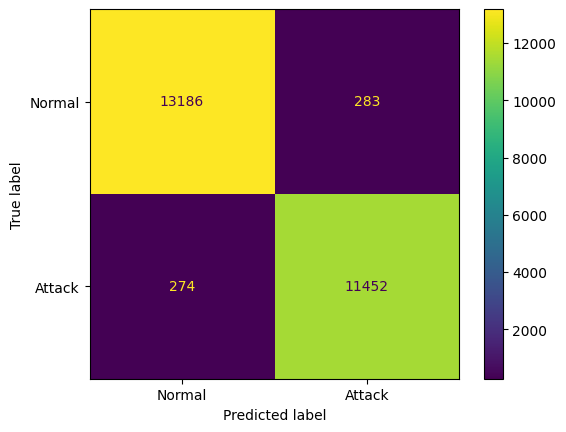

In [56]:
y_test_bin_pred = best_model_bin.predict(X_test_bin)

print(classification_report(
    y_test_bin,
    y_test_bin_pred,
    target_names=["Normal", "Attack"]
))

y_test_bin_proba = best_model_bin.predict_proba(X_test_bin)[:, 1]
roc_auc = roc_auc_score(y_test_bin, y_test_bin_proba)
print("ROC-AUC:", round(roc_auc,4))

cm = confusion_matrix(y_test_bin, y_test_bin_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Normal", "Attack"],
).plot(values_format='d')

plt.show()

**Insights:**

- The confusion matrix shows very low misclassification, with only 283 Normal and 274 Attack samples incorrectly predicted.

- Precision, recall, and F1-score are all 0.98 for both classes, indicating balanced and reliable classification performance.

- Overall accuracy of 98% suggests the model generalizes well without favoring either class.

- A high ROC-AUC of 0.9969 confirms excellent separability between Normal and Attack traffic.

### 5.6 **Feature Importances**

In [114]:
ct = best_model_bin.named_steps['preprocess']
ohe = ct.named_transformers_['cat'].named_steps['ohe']
cat_input_features = ct.transformers_[0][2]
cat_feature_names = ohe.get_feature_names_out(cat_input_features)
num_feature_names = ct.transformers_[1][2]
feature_names = list(cat_feature_names) + list(num_feature_names)
feature_names

['protocoltype_icmp',
 'protocoltype_tcp',
 'protocoltype_udp',
 'service_domain_u',
 'service_eco_i',
 'service_ecr_i',
 'service_finger',
 'service_ftp',
 'service_ftp_data',
 'service_http',
 'service_other',
 'service_private',
 'service_smtp',
 'service_telnet',
 'service_infrequent_sklearn',
 'flag_REJ',
 'flag_RSTO',
 'flag_RSTR',
 'flag_S0',
 'flag_SF',
 'flag_infrequent_sklearn',
 'duration',
 'srcbytes',
 'dstbytes',
 'hot',
 'numcompromised',
 'count',
 'srvcount',
 'serrorrate',
 'srvserrorrate',
 'rerrorrate',
 'srvrerrorrate',
 'samesrvrate',
 'diffsrvrate',
 'srvdiffhostrate',
 'dsthostcount',
 'dsthostsrvcount',
 'dsthostsamesrvrate',
 'dsthostdiffsrvrate',
 'dsthostsamesrcportrate',
 'dsthostsrvdiffhostrate',
 'dsthostserrorrate',
 'dsthostsrvserrorrate',
 'dsthostrerrorrate',
 'dsthostsrvrerrorrate']

In [ ]:
clf = best_model_bin.named_steps['clf']
coefs = clf.coef_[0]

importance = pd.DataFrame({
    'feature': feature_names,
    'coef': coefs,
}).sort_values('coef', ascending=True)

importance

,feature,coef
7,service_ftp,-8.7724
15,flag_REJ,-6.2029
3,service_domain_u,-3.2262
13,service_telnet,-3.0794
10,service_other,-2.1889
20,flag_infrequent_sklearn,-2.1359
0,protocoltype_icmp,-1.7807
28,serrorrate,-1.3448
36,dsthostsrvcount,-1.2570
21,duration,-0.9558


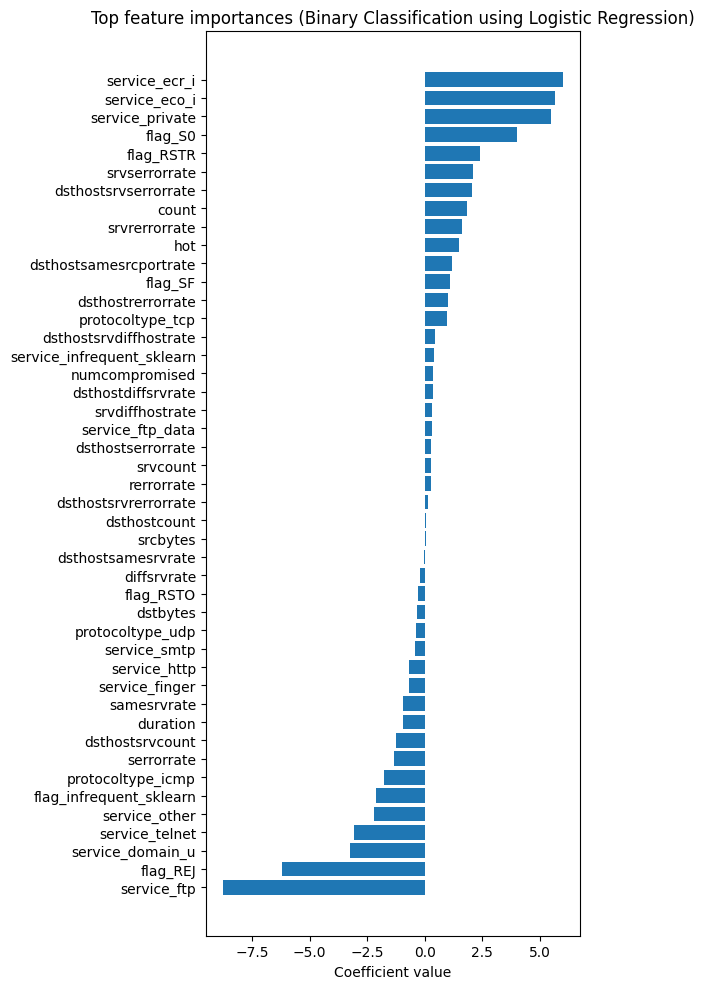

In [61]:
plt.figure(figsize=(6, 10))
plt.barh(importance["feature"], importance["coef"])
plt.xlabel("Coefficient value")
plt.title("Top feature importances (Binary Classification using Logistic Regression)")
plt.tight_layout()
plt.show()

In [62]:
feature_categories = {
'basic_connection_features' : ['duration','srcbytes','dstbytes'] + [f for f in feature_names if 'service' in f or 'flag' in f or 'protocol' in f],
'content_related_features' : ['hot','numcompromised'],
'time_related_traffic_features' : ['count','serrorrate','rerrorrate','samesrvrate','diffsrvrate'] + [f for f in feature_names if f[:3] == 'srv' and f != 'srvbytes'],
'host_based_traffic_features' : [f for f in feature_names if f[:3] == 'dst' and f != 'dstbytes']
}

assert sum([len(value) for key,value in feature_categories.items()]) == len(feature_names)

In [63]:
COEF_THRESHOLD = 1

markdown_text = f"""
**Insights:**

* Features with **Strong Positive Coefficients (>{COEF_THRESHOLD})**, indicating increased likelihood of an **ATTACK**:

    * Basic Connection Features:
    
        {sorted(['`'+f+'`' for f in feature_categories['basic_connection_features'] if importance.loc[importance['feature'] == f, 'coef'].iloc[0] > COEF_THRESHOLD])}

    * Content-Related Features:

        {sorted(['`'+f+'`' for f in feature_categories['content_related_features'] if importance.loc[importance['feature'] == f, 'coef'].iloc[0] > COEF_THRESHOLD])}

    * Time-Related Traffic Features:

        {sorted(['`'+f+'`' for f in feature_categories['time_related_traffic_features'] if importance.loc[importance['feature'] == f, 'coef'].iloc[0] > COEF_THRESHOLD])}

    * Host-based Traffic Features:

        {sorted(['`'+f+'`' for f in feature_categories['host_based_traffic_features'] if importance.loc[importance['feature'] == f, 'coef'].iloc[0] > COEF_THRESHOLD])}
"""

display(Markdown(markdown_text))

markdown_text = f"""

* Features with **Strong Negative Coefficients (<{-COEF_THRESHOLD})**, indicating increased likelihood of a **NORMAL ACTIVITY**:

    * Basic Connection Features:
    
        {sorted(['`'+f+'`' for f in feature_categories['basic_connection_features'] if importance.loc[importance['feature'] == f, 'coef'].iloc[0] < -COEF_THRESHOLD])}

    * Content-Related Features:

        {sorted(['`'+f+'`' for f in feature_categories['content_related_features'] if importance.loc[importance['feature'] == f, 'coef'].iloc[0] < -COEF_THRESHOLD])}

    * Time-Related Traffic Features:

        {sorted(['`'+f+'`' for f in feature_categories['time_related_traffic_features'] if importance.loc[importance['feature'] == f, 'coef'].iloc[0] < -COEF_THRESHOLD])}

    * Host-based Traffic Features:

        {sorted(['`'+f+'`' for f in feature_categories['host_based_traffic_features'] if importance.loc[importance['feature'] == f, 'coef'].iloc[0] < -COEF_THRESHOLD])}

"""

display(Markdown(markdown_text))


**Insights:**

* Features with **Strong Positive Coefficients (>1)**, indicating increased likelihood of an **ATTACK**:

    * Basic Connection Features:

        ['`flag_RSTR`', '`flag_S0`', '`flag_SF`', '`service_eco_i`', '`service_ecr_i`', '`service_private`']

    * Content-Related Features:

        ['`hot`']

    * Time-Related Traffic Features:

        ['`count`', '`srvrerrorrate`', '`srvserrorrate`']

    * Host-based Traffic Features:

        ['`dsthostrerrorrate`', '`dsthostsamesrcportrate`', '`dsthostsrvserrorrate`']




* Features with **Strong Negative Coefficients (<-1)**, indicating increased likelihood of a **NORMAL ACTIVITY**:

    * Basic Connection Features:

        ['`flag_REJ`', '`flag_infrequent_sklearn`', '`protocoltype_icmp`', '`service_domain_u`', '`service_ftp`', '`service_other`', '`service_telnet`']

    * Content-Related Features:

        []

    * Time-Related Traffic Features:

        ['`serrorrate`']

    * Host-based Traffic Features:

        ['`dsthostsrvcount`']



### 5.7 Saving the best model

In [65]:
dump(best_model_bin, '../artifacts/binary_model.joblib')

['../artifacts/binary_model.joblib']

## 6. Modelling - Multiclass Classification (Attack Type - DoS/Probe/R2L/U2R)

### 6.1 Models

In [66]:
y_train_multi.value_counts()

attacktype
DoS      36822
Probe     9267
R2L        769
U2R         46
Name: count, dtype: int64

In [67]:
smote = SMOTE(sampling_strategy={'R2L':2000, 'U2R':500}, random_state=42)

In [68]:
models_multi = {

    'logistic_ovr': ImbPipeline([
        ('preprocess', preprocess_linear),
        ('smote', smote),
        ('clf', LogisticRegression(
            max_iter=2000,
            multi_class='ovr',
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        ))
    ]),

    'linear_svc_ovr': ImbPipeline([
        ('preprocess', preprocess_linear),
        ('smote', smote),
        ('clf', LinearSVC(
            class_weight='balanced',
            random_state=42
        ))
    ]),

    'rf': ImbPipeline([
        ('preprocess', preprocess_tree),
        ('smote', smote),
        ('clf', RandomForestClassifier(
            class_weight='balanced',
            n_jobs=-1,
            random_state=42
        ))
    ]),

    'adaboost': ImbPipeline([
        ('preprocess', preprocess_tree),
        ('smote', smote),
        ('clf', AdaBoostClassifier(
            estimator=DecisionTreeClassifier(),
            random_state=42
        ))
    ]),

    'gradboost': ImbPipeline([
        ('preprocess', preprocess_tree),
        ('smote', smote),
        ('clf', GradientBoostingClassifier(
            n_estimators=500,
            n_iter_no_change=10,
            random_state=42
        ))
    ])
}

### 6.2 Distribution Grids for Randomized Search Cross-Validation

In [69]:
logreg_dist_multi = {
    'clf__C': stats.loguniform(1e-3, 1e2)
}

linearsvc_dist_multi = {
    'clf__C': stats.loguniform(1e-3, 1e2)
}

rf_dist_multi = {
    'clf__n_estimators': stats.randint(100, 500),
    'clf__max_depth': [10, 20, 30],
    'clf__min_samples_split': stats.randint(2, 20),
    'clf__min_samples_leaf': stats.randint(1, 10),
    'clf__max_features': ['sqrt', 'log2']
}

adaboost_dist_multi = {
    'clf__n_estimators': stats.randint(100, 500),
    'clf__learning_rate': stats.loguniform(1e-3, 1),
    'clf__estimator__max_depth': [1, 2, 3]
}

gradboost_dist_multi = {
    'clf__max_depth': stats.randint(2, 6),
    'clf__learning_rate': stats.loguniform(1e-3, 1),
    'clf__subsample': stats.uniform(0.6, 0.4)
}

param_dists_multi = {
    'logistic_ovr': logreg_dist_multi,
    'linear_svc_ovr': linearsvc_dist_multi,
    'rf': rf_dist_multi,
    'adaboost': adaboost_dist_multi,
    'gradboost': gradboost_dist_multi
}

### 6.3 Defining Cross Validation and Scoring Functions

In [ ]:
skf = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scoring_multi = {
    'accuracy': 'accuracy',
    'f1': 'f1_macro',
    'precision': 'precision_macro',
    'recall': 'recall_macro'
}

### 6.4 RandomizedSearchCV

In [71]:
results_multi = {}

print('='*100)
t = 'RANDOMIZED SEARCH CV FOR MULTICLASS CLASSIFICATION'
print(' '*int((100-len(t))/2),t,' '*int((100-len(t))/2))
print('='*100)

for name, model in models_multi.items():
    print('\n')
    print(f"Running RSCV for {name.upper()}...")
    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dists_multi[name],
        n_iter=10,
        cv=skf,
        scoring=scoring_multi,
        refit='f1',
        n_jobs=1,
        random_state=42,
        verbose=1
        )
    
    rs.fit(X_train_multi, y_train_multi)
    
    results_multi[name] = {
    'best_estimator': rs.best_estimator_,
    'best_score': rs.best_score_,
    'best_params': rs.best_params_,
    'cv_results': {
        k: rs.cv_results_[k].mean()
        for k in rs.cv_results_
        if k.startswith('mean_test_')
    }}
    print('\n')
    print('-'*100)

                          RANDOMIZED SEARCH CV FOR MULTICLASS CLASSIFICATION                          


Running RSCV for LOGISTIC_OVR...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


----------------------------------------------------------------------------------------------------


Running RSCV for LINEAR_SVC_OVR...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


----------------------------------------------------------------------------------------------------


Running RSCV for RF...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


----------------------------------------------------------------------------------------------------


Running RSCV for ADABOOST...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


----------------------------------------------------------------------------------------------------


Running RSCV for GRADBOOST...
Fitting 5 folds for each of 10 candidates, totalling 50 fits


------------------

In [72]:
print('='*100)
t = 'MULTICLASS CLASSIFICATION RESULTS'
print(' '*int((100-len(t))/2),t,' '*int((100-len(t))/2))
print('='*100)

for name, scores in results_multi.items():
    print('\n')
    print(f"{name.upper()}:")
    # print('\t', scores['best_estimator'])
    print('\t', 'Best F1 Score =', round(scores['best_score'],4))
    print('\t', 'Best Params:')
    for param, value in scores['best_params'].items():
        if isinstance(value, (int, float)):
            value = round(value,4)
        print('\t\t', param, ':', value)
    print('\t', 'CV Results:')
    print('\t\t', 'Mean Validation Accuracy = ', round(scores['cv_results']['mean_test_accuracy'],4))
    print('\t\t', 'Mean Validation F1 Score = ', round(scores['cv_results']['mean_test_f1'],4))
    print('\t\t', 'Mean Validation Recall = ', round(scores['cv_results']['mean_test_recall'],4))
    print('\t\t', 'Mean Validation Precision = ', round(scores['cv_results']['mean_test_precision'],4))
    print('\n')
    print('-'*100)

                                  MULTICLASS CLASSIFICATION RESULTS                                  


LOGISTIC_OVR:
	 Best F1 Score = 0.9217
	 Best Params:
		 clf__C : 56.6985
	 CV Results:
		 Mean Validation Accuracy =  0.9945
		 Mean Validation F1 Score =  0.8967
		 Mean Validation Recall =  0.9585
		 Mean Validation Precision =  0.8654


----------------------------------------------------------------------------------------------------


LINEAR_SVC_OVR:
	 Best F1 Score = 0.931
	 Best Params:
		 clf__C : 0.9847
	 CV Results:
		 Mean Validation Accuracy =  0.9969
		 Mean Validation F1 Score =  0.9166
		 Mean Validation Recall =  0.9508
		 Mean Validation Precision =  0.8995


----------------------------------------------------------------------------------------------------


RF:
	 Best F1 Score = 0.8006
	 Best Params:
		 clf__max_depth : 30
		 clf__max_features : log2
		 clf__min_samples_leaf : 5
		 clf__min_samples_split : 3
		 clf__n_estimators : 443
	 CV Results:
		 Mean Valid

In [73]:
best_model_multi_name = max(
    results_multi,
    key=lambda name: results_multi[name]['best_score']
)

best_model_multi = results_multi[best_model_multi_name]['best_estimator']
best_score_multi = results_multi[best_model_multi_name]['best_score']

print("BEST MODEL (MULTICLASS CLF):", best_model_multi_name)
print("BEST CV F1 SCORE:", round(best_score_multi,4))

BEST MODEL (MULTICLASS CLF): linear_svc_ovr
BEST CV F1 SCORE: 0.931


In [74]:
best_model_multi

,steps,"[('preprocess', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num_ordinal', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 6.5 Performance of Best Model on Test Data

              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9105
       Probe       0.99      1.00      0.99      2389
         R2L       0.98      0.96      0.97       226
         U2R       0.43      1.00      0.60         6

    accuracy                           1.00     11726
   macro avg       0.85      0.99      0.89     11726
weighted avg       1.00      1.00      1.00     11726



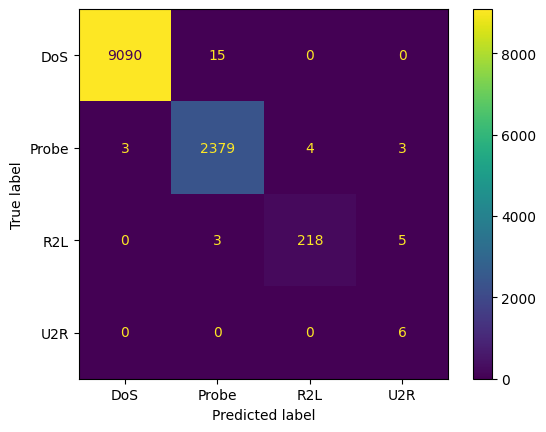

In [75]:
y_test_multi_pred = best_model_multi.predict(X_test_multi)

print(classification_report(
    y_test_multi,
    y_test_multi_pred
))

cm = confusion_matrix(y_test_multi, y_test_multi_pred)

ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=np.unique(y_test_multi)
).plot(values_format='d')

plt.show()

**Insights from Classification Report:**


- DoS and Probe achieve near-perfect precision, recall, and F1-score with very large support, indicating extremely reliable detection.

- R2L shows slightly lower recall (0.96), meaning some R2L attacks are missed, but overall performance remains high.

- U2R has perfect recall but very low precision (0.43), indicating many false positives despite detecting all true U2R samples.

- Macro averages are noticeably lower than weighted averages, highlighting the impact of severe class imbalance.

**Insights from Confusion Matrix:**

- DoS is classified with extremely high accuracy, with only 15 misclassifications out of 9,105 total DoS samples.

- Probe shows strong performance, but minor confusion exists with R2L and U2R, indicating some overlap in attack behavior.

- R2L has the weakest performance relative to its size, with noticeable misclassification into U2R and Probe.

- U2R has perfect precision in this matrix, but the very small sample size (6) limits confidence in robustness.

- Overall errors are rare and mostly occur between Probe, R2L, and U2R, suggesting these classes are harder to separate.

- The confusion matrix is highly imbalanced, so accuracy alone may be misleading without recall and F1-score analysis.

### 6.6 **Feature Importances**

#### 6.6.1 Extracting Feature Names Used in the model

In [76]:
ct = best_model_multi.named_steps['preprocess']
ohe = ct.named_transformers_['cat'].named_steps['ohe']
cat_input_features = ct.transformers_[0][2]
cat_feature_names = ohe.get_feature_names_out(cat_input_features)
num_feature_names = ct.transformers_[1][2]
feature_names = list(cat_feature_names) + list(num_feature_names)
feature_names

['protocoltype_icmp',
 'protocoltype_tcp',
 'protocoltype_udp',
 'service_Z39_50',
 'service_auth',
 'service_bgp',
 'service_courier',
 'service_eco_i',
 'service_ecr_i',
 'service_finger',
 'service_ftp',
 'service_ftp_data',
 'service_http',
 'service_imap4',
 'service_iso_tsap',
 'service_nnsp',
 'service_other',
 'service_private',
 'service_telnet',
 'service_uucp',
 'service_uucp_path',
 'service_vmnet',
 'service_whois',
 'service_infrequent_sklearn',
 'flag_REJ',
 'flag_RSTO',
 'flag_RSTR',
 'flag_S0',
 'flag_SF',
 'flag_infrequent_sklearn',
 'duration',
 'srcbytes',
 'dstbytes',
 'hot',
 'numcompromised',
 'count',
 'srvcount',
 'serrorrate',
 'srvserrorrate',
 'rerrorrate',
 'srvrerrorrate',
 'samesrvrate',
 'diffsrvrate',
 'srvdiffhostrate',
 'dsthostcount',
 'dsthostsrvcount',
 'dsthostsamesrvrate',
 'dsthostdiffsrvrate',
 'dsthostsamesrcportrate',
 'dsthostsrvdiffhostrate',
 'dsthostserrorrate',
 'dsthostsrvserrorrate',
 'dsthostrerrorrate',
 'dsthostsrvrerrorrate']

In [77]:
feature_categories = {
'basic_connection_features' : ['duration','srcbytes','dstbytes'] + [f for f in feature_names if 'service' in f or 'flag' in f or 'protocol' in f],
'content_related_features' : ['hot','numcompromised'],
'time_related_traffic_features' : ['count','serrorrate','rerrorrate','samesrvrate','diffsrvrate'] + [f for f in feature_names if f[:3] == 'srv' and f != 'srvbytes'],
'host_based_traffic_features' : [f for f in feature_names if f[:3] == 'dst' and f != 'dstbytes']
}

assert sum([len(value) for key,value in feature_categories.items()]) == len(feature_names)

In [87]:
def feature_imp(attack, COEF_THRESHOLD=0):
    clf = best_model_multi.named_steps['clf']
    class_idx = list(clf.classes_).index(attack)
    coefs = clf.coef_[class_idx]

    imp = (
        pd.DataFrame({
            "feature": feature_names,
            "coef": coefs
        })
        .sort_values("coef", ascending=True)
    )

    plt.figure(figsize=(6, 10))
    plt.barh(imp["feature"], imp["coef"])
    plt.xlabel("Coefficient value")
    plt.title(f"Top feature importances for {attack} (Multiclass Classification)")
    plt.tight_layout()
    plt.show()

    markdown_text = f"""
**Insights:**

* Features with **Strong Positive Coefficients (>{COEF_THRESHOLD})**, indicating increased likelihood of a **{attack.upper()} ATTACK**:

    * Basic Connection Features:
    
        {sorted(['`'+f+'`' for f in feature_categories['basic_connection_features'] if imp.loc[imp['feature'] == f, 'coef'].iloc[0] > COEF_THRESHOLD])}

    * Content-Related Features:

        {sorted(['`'+f+'`' for f in feature_categories['content_related_features'] if imp.loc[imp['feature'] == f, 'coef'].iloc[0] > COEF_THRESHOLD])}

    * Time-Related Traffic Features:

        {sorted(['`'+f+'`' for f in feature_categories['time_related_traffic_features'] if imp.loc[imp['feature'] == f, 'coef'].iloc[0] > COEF_THRESHOLD])}

    * Host-based Traffic Features:

        {sorted(['`'+f+'`' for f in feature_categories['host_based_traffic_features'] if imp.loc[imp['feature'] == f, 'coef'].iloc[0] > COEF_THRESHOLD])}
"""

    display(Markdown(markdown_text))

#### 6.6.2 DoS

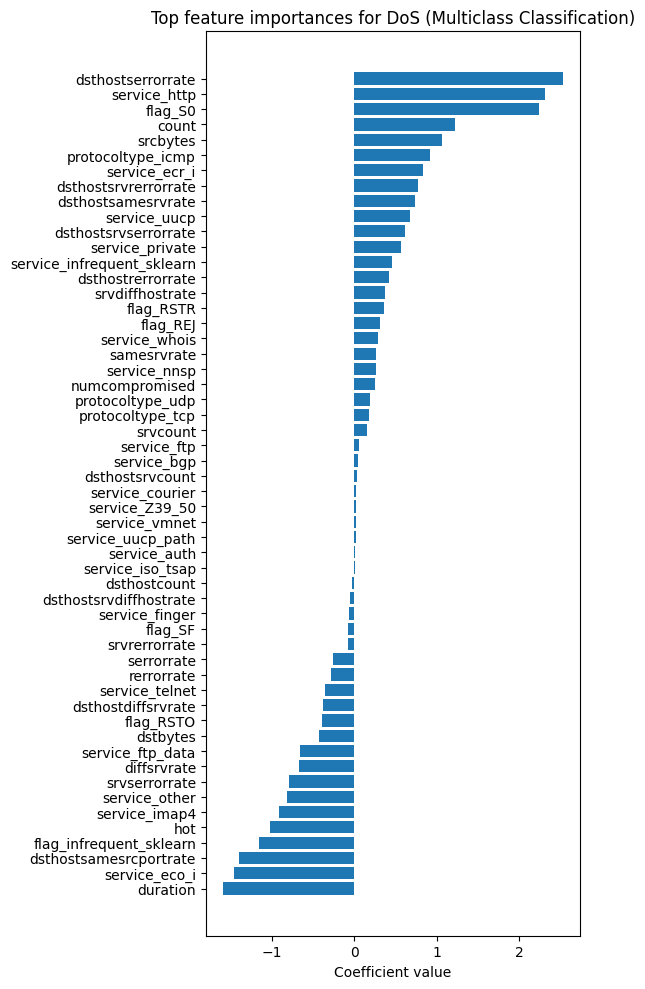


**Insights:**

* Features with **Strong Positive Coefficients (>0.5)**, indicating increased likelihood of a **DOS ATTACK**:

    * Basic Connection Features:

        ['`flag_S0`', '`protocoltype_icmp`', '`service_ecr_i`', '`service_http`', '`service_private`', '`service_uucp`', '`srcbytes`']

    * Content-Related Features:

        []

    * Time-Related Traffic Features:

        ['`count`']

    * Host-based Traffic Features:

        ['`dsthostsamesrvrate`', '`dsthostserrorrate`', '`dsthostsrvrerrorrate`', '`dsthostsrvserrorrate`']


In [89]:
feature_imp('DoS',0.5)

#### 6.6.3 Probe

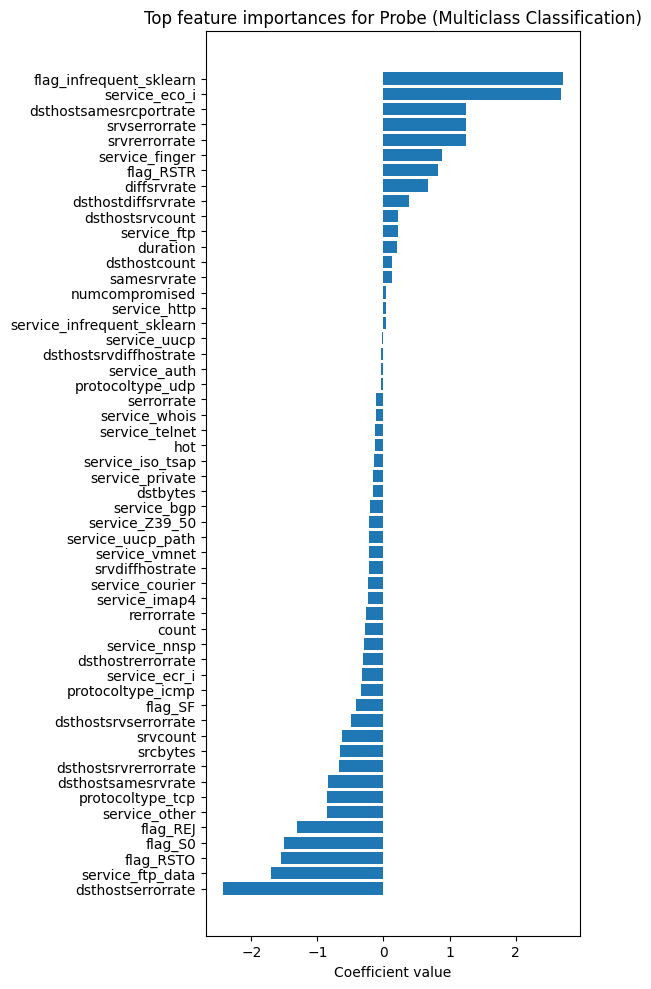


**Insights:**

* Features with **Strong Positive Coefficients (>0.5)**, indicating increased likelihood of a **PROBE ATTACK**:

    * Basic Connection Features:

        ['`flag_RSTR`', '`flag_infrequent_sklearn`', '`service_eco_i`', '`service_finger`']

    * Content-Related Features:

        []

    * Time-Related Traffic Features:

        ['`diffsrvrate`', '`srvrerrorrate`', '`srvserrorrate`']

    * Host-based Traffic Features:

        ['`dsthostsamesrcportrate`']


In [90]:
feature_imp('Probe',0.5)

#### 6.6.4 R2L

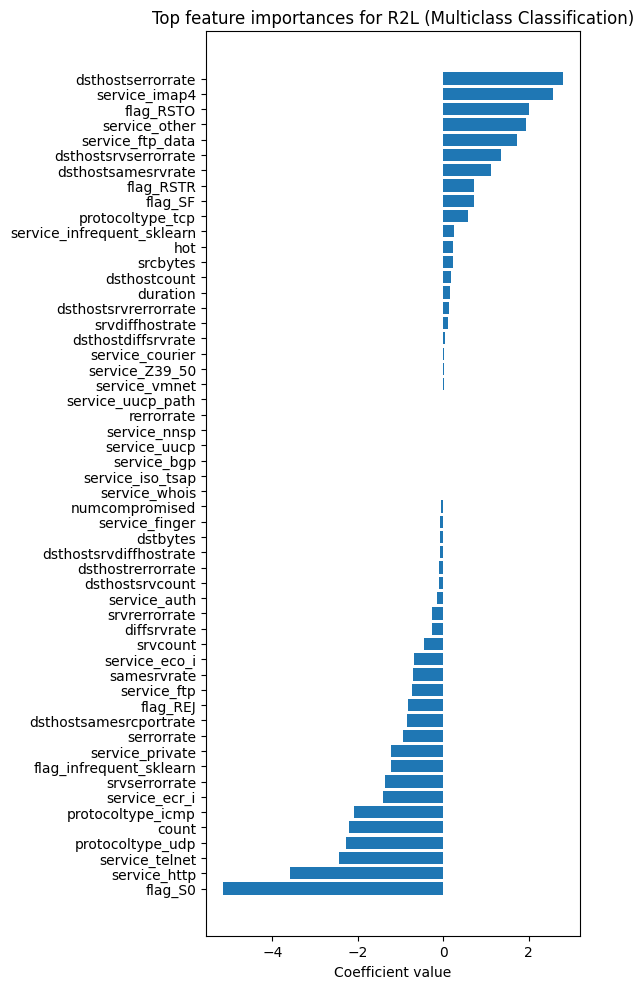


**Insights:**

* Features with **Strong Positive Coefficients (>0.5)**, indicating increased likelihood of a **R2L ATTACK**:

    * Basic Connection Features:

        ['`flag_RSTO`', '`flag_RSTR`', '`flag_SF`', '`protocoltype_tcp`', '`service_ftp_data`', '`service_imap4`', '`service_other`']

    * Content-Related Features:

        []

    * Time-Related Traffic Features:

        []

    * Host-based Traffic Features:

        ['`dsthostsamesrvrate`', '`dsthostserrorrate`', '`dsthostsrvserrorrate`']


In [91]:
feature_imp('R2L',0.5)

#### 6.6.5 U2R

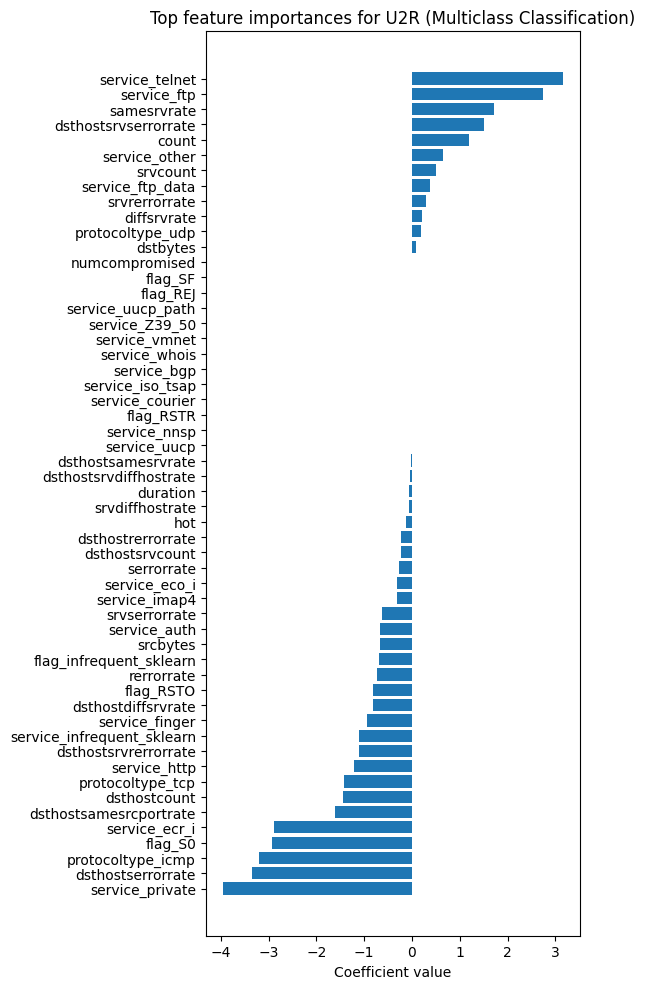


**Insights:**

* Features with **Strong Positive Coefficients (>0.5)**, indicating increased likelihood of a **U2R ATTACK**:

    * Basic Connection Features:

        ['`service_ftp`', '`service_other`', '`service_telnet`']

    * Content-Related Features:

        []

    * Time-Related Traffic Features:

        ['`count`', '`samesrvrate`']

    * Host-based Traffic Features:

        ['`dsthostsrvserrorrate`']


In [93]:
feature_imp('U2R',0.5)

### 6.7 Saving the best model

In [94]:
best_model_multi.named_steps

{'preprocess': ColumnTransformer(transformers=[('cat',
                                  Pipeline(steps=[('ohe',
                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                 min_frequency=0.01))]),
                                  ['protocoltype', 'service', 'flag']),
                                 ('num_ordinal',
                                  Pipeline(steps=[('log',
                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                       func=<ufunc 'log1p'>)),
                                                  ('scale', StandardScaler())]),
                                  ['duration', 'srcbytes', 'dstbytes', 'hot',
                                   'numcompromised', 'count', 'srvcount',
                                   'serrorrate', 'srvserrorrate', 'rerrorrate',
     

In [95]:
preprocessor_multi = best_model_multi.named_steps['preprocess']
classifier_multi = best_model_multi.named_steps['clf']

In [96]:
deploy_pipeline = Pipeline(steps=[
    ('preprocess', preprocessor_multi),
    ('classifier', classifier_multi)
])

In [97]:
dump(deploy_pipeline, "../artifacts/multiclass_model.joblib")

['../artifacts/multiclass_model.joblib']